## By Yiduan Donna Zheng

### Note: there is an significant error in the dml_est_tau function in the old notebook; please refer to this notebook for all results.

## Part 0: Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
pd.set_option('display.max_columns', None)

In [211]:
# load data here
# may not use everything, reading just in case
# thanks to Tim's notebook - able to simplify the code by a lot!
file_path = 'OHIE_dta/'
des_data = pd.read_stata(file_path+'oregonhie_descriptive_vars.dta')
state_data = pd.read_stata(file_path+'oregonhie_stateprograms_vars.dta')
s0m_data = pd.read_stata(file_path+'oregonhie_survey0m_vars.dta')
s6m_data = pd.read_stata(file_path+'oregonhie_survey6m_vars.dta')
s12m_data = pd.read_stata(file_path+'oregonhie_survey12m_vars.dta')
ips_data = pd.read_stata(file_path+'oregonhie_inperson_vars.dta')
ed_data = pd.read_stata(file_path+'oregonhie_ed_vars.dta')
pat_data = pd.read_stata(file_path+'oregonhie_patterns_vars.dta')

In [212]:
des_data = des_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

In [213]:
des_data['applied_app'].replace(-1, 0, inplace=True)
des_data['approved_app'].replace(-1, 0, inplace=True)
des_data['OHIE_app_ins'] = des_data['treatment'] * des_data['applied_app'] * des_data['approved_app']
# this is my very dumb approach to keep track of who got insurance through the lottery
# may not be useful, but it is here
#des_data[:10]

In [214]:
des_data.replace(-1, np.nan, inplace=True)
des_subdata = des_data[['person_id', 'household_id', 'treatment', 'draw_lottery', 'applied_app', 'approved_app', 
                        'numhh_list', 'birthyear_list', 'have_phone_list', 'english_list', 'female_list', 
                        'first_day_list', 'last_day_list', 'pobox_list', 'self_list', 'week_list', 'zip_msa_list', 'OHIE_app_ins']]
des_subdata.loc[:,"numhh_list"] = des_subdata["numhh_list"] + 1

In [215]:
# des_subdata['OHIE_app_ins'] = des_subdata['treatment'] * des_subdata['applied_app'] * des_subdata['approved_app']
des_subdata['age'] = 2009 - des_subdata['birthyear_list']
des_subdata[:5]

/var/folders/dc/j_9rc1xd6xj5836y93540spc0000gn/T/ipykernel_18310/798873206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  des_subdata['age'] = 2009 - des_subdata['birthyear_list']


,person_id,household_id,treatment,draw_lottery,applied_app,approved_app,numhh_list,birthyear_list,have_phone_list,english_list,female_list,first_day_list,last_day_list,pobox_list,self_list,week_list,zip_msa_list,OHIE_app_ins,age
0,1.0,100001.0,1,6,1,0,1,1978,1,1,0.0,0,0,1,1,1,1.0,0,31
1,2.0,100002.0,1,5,0,0,1,1984,1,1,1.0,0,0,0,1,2,1.0,0,25
2,3.0,100003.0,0,1,0,0,1,1971,1,1,1.0,0,0,0,1,2,1.0,0,38
3,4.0,100004.0,0,7,0,0,1,1955,1,1,1.0,0,0,0,1,0,1.0,0,54
4,5.0,100005.0,1,6,0,0,1,1969,1,0,1.0,0,0,0,1,1,1.0,0,40


In [216]:
state_data = state_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
state_data.replace(-1, np.nan, inplace=True)

In [15]:
# do not use!
state_vars1 = ['person_id', 'ohp_all_ever_matchn_30sep2009','ohp_all_end_30sep2009', 'ohp_all_mo_matchn_30sep2009', 
              'snap_ever_prenotify07', 'snap_ever_matchn_30sep2009', 'snap_tot_hh_prenotify07',
              'snap_tot_hh_30sep2009', 'tanf_ever_prenotify07', 'tanf_ever_matchn_30sep2009',
               'tanf_tot_hh_prenotify07', 'tanf_tot_hh_30sep2009']
state_subdata1 = pd.DataFrame(state_data[state_vars1])

In [64]:
# do not use!
state_vars2 = ['person_id', 'ohp_all_ever_firstn_30sep2009','ohp_all_end_30sep2009', 'ohp_all_mo_firstn_30sep2009',
              'snap_ever_presurvey12m', 'snap_ever_firstn_survey12m', 'snap_tot_hh_presurvey12m',
              'snap_tot_hh_firstn_survey12m', 'tanf_ever_presurvey12m', 'tanf_ever_firstn_survey12m',
               'tanf_tot_hh_presurvey12m', 'tanf_tot_hh_firstn_survey12m']
state_subdata2 = pd.DataFrame(state_data[state_vars2])

In [217]:
# want to keep all treatment vars and covariates for later robustness check
state_vars = ['person_id', 'ohp_all_ever_matchn_30sep2009','ohp_all_end_30sep2009', 'ohp_all_mo_matchn_30sep2009', 
              'snap_ever_prenotify07', 'snap_ever_matchn_30sep2009', 'snap_tot_hh_prenotify07',
              'snap_tot_hh_30sep2009', 'tanf_ever_prenotify07', 'tanf_ever_matchn_30sep2009',
              'tanf_tot_hh_prenotify07', 'tanf_tot_hh_30sep2009',
              'ohp_all_ever_firstn_30sep2009','ohp_all_end_30sep2009', 'ohp_all_mo_firstn_30sep2009',
              'snap_ever_presurvey12m', 'snap_ever_firstn_survey12m', 'snap_tot_hh_presurvey12m',
              'snap_tot_hh_firstn_survey12m', 'tanf_ever_presurvey12m', 'tanf_ever_firstn_survey12m',
               'tanf_tot_hh_presurvey12m', 'tanf_tot_hh_firstn_survey12m']
state_subdata = pd.DataFrame(state_data[state_vars])

In [18]:
# these two do have differences (albeit not sure significant)
#state_subdata['ohp_all_ever_matchn_30sep2009'].value_counts()
#NOT enrolled    56909
#Enrolled        18013
#state_subdata['ohp_all_ever_firstn_30sep2009'].value_counts() # codebook is wrong
#NOT enrolled    56563
#Enrolled        18359

# there's smth interesting going on here, but not quite sure what
# for difference firstn and matchn, see codebook
# I was going to use matchn, but then Finkelstein (2012) used firstn and I cannot find their rationale for doing so...
# so maybe do matchn (which I find it easier to justify logically), and then we can do it against firstn for robustness check??

In [218]:
# Survey 12
s12m_data = s12m_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
s12m_data.replace(-1, np.nan, inplace=True)

In [219]:
s12m_data.head()

,person_id,sample_12m,dt_mail_12m,dt_returned_12m,ret_mode_12m,returned_12m,surv_lang_12m,in_survey_12m,sample_12m_resp,sample_12m_nonresp,sample_12m_nonzeroweight,weight_intensive_12m,weight_newlottery_12m,weight_12m,wave_survey12m,protocol_12m,ins_any_12m,ins_ohp_12m,ins_medicare_12m,ins_employer_12m,ins_privpay_12m,ins_othcov_12m,ins_noins_12m,ins_private_12m,ins_other_12m,ins_months_12m,usual_place_12m,usual_care_12m,usual_clinic_12m,usual_doc_12m,need_med_12m,needmet_qn_med_12m,needmet_med_12m,reason_care_cost_12m,reason_care_ins_12m,reason_care_doc_12m,reason_care_owe_12m,reason_care_apt_12m,reason_care_closed_12m,reason_care_nodoc_12m,reason_care_other_12m,reason_care_dont_12m,need_rx_12m,needmet_qn_rx_12m,needmet_rx_12m,reason_rx_cost_12m,reason_rx_ins_12m,reason_rx_doc_12m,reason_rx_get_12m,reason_rx_pharm_12m,reason_rx_other_12m,reason_rx_dont_12m,rx_any_12m,rx_num_mod_12m,need_dent_12m,needmet_qn_dent_12m,needmet_dent_12m,doc_any_12m,doc_num_mod_12m,er_any_12m,er_num_mod_12m,reason_er_need_12m,reason_er_insure_12m,reason_er_closed_12m,reason_er_apt_12m,reason_er_doc_12m,reason_er_copay_12m,reason_er_go_12m,reason_er_other_12m,reason_er_rx_12m,reason_er_dont_12m,er_noner_12m,hosp_any_12m,hosp_num_mod_12m,med_qual_12m,med_qual_bin_12m,cost_any_oop_12m,cost_doc_oop_12m,cost_er_oop_12m,cost_rx_oop_12m,cost_oth_oop_12m,cost_tot_oop_12m,cost_any_owe_12m,cost_tot_owe_12m,cost_borrow_12m,cost_refused_12m,happiness_12m,health_gen_12m,health_gen_bin_12m,health_chg_12m,health_chg_bin_12m,baddays_phys_12m,baddays_ment_12m,baddays_tot_12m,health_work_12m,physical_act_12m,dep_interest_12m,dep_sad_12m,dia_dx_12m,ast_dx_12m,hbp_dx_12m,emp_dx_12m,ami_dx_12m,chf_dx_12m,dep_dx_12m,chl_dx_12m,kid_dx_12m,dia_rx_12m,ast_rx_12m,hbp_rx_12m,emp_rx_12m,ami_rx_12m,chf_rx_12m,dep_rx_12m,chl_rx_12m,kid_rx_12m,chl_chk_12m,dia_chk_12m,mam_chk_12m,pap_chk_12m,smk_ever_12m,smk_curr_12m,smk_avg_mod_12m,smk_quit_12m,female_12m,birthyear_12m,employ_12m,employ_det_12m,employ_hrs_12m,hhinc_cat_12m,hhinc_pctfpl_12m,race_hisp_12m,race_white_12m,race_black_12m,race_amerindian_12m,race_asian_12m,race_pacific_12m,race_other_qn_12m,edu_12m,live_partner_12m,live_alone_12m,live_parents_12m,live_relatives_12m,live_friends_12m,live_other_12m,hhsize_12m,num19_12m,needmet_med_cor_12m,needmet_rx_cor_12m,needmet_dent_cor_12m
0,1.0,1,5.0,2009-11-24,Mail,1.0,English,1.0,1,0,1,1.0,1.000000,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,15.0,30.0,20.0,0.0,2.0,3.0,3.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,NaN,NaN,1.0,2.0,0.0,NaN,0.0,1978.0,0.0,2.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
1,2.0,1,5.0,2009-08-31,Mail,1.0,English,1.0,1,0,1,1.0,1.000000,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,2.0,0.0,1.0,0.0,3.0,12.0,6.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0,2.0,0.0,NaN,1.0,1984.0,1.0,0.0,2.0,4.0,60.054909,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,3.0,1,3.0,NaT,,0.0,,0.0,0,0,0,0.0,1.046526,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [220]:
data12m = pd.merge(des_subdata, state_subdata, on='person_id', how='left')

In [221]:
data12m = pd.merge(data12m, s12m_data, on='person_id', how='left')

In [31]:
#data12m.head(10)

In [32]:
from sklearn.preprocessing import OrdinalEncoder

In [222]:
fdata12m = data12m.filter(regex='^(?!.*_y$)')
fdata12m = fdata12m.rename(lambda x: x.replace('_x', ''), axis=1)
fdata12m = fdata12m.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'object' else x)
datetime_columns = fdata12m.select_dtypes('datetime64[ns]').columns
ordinal_encoder = OrdinalEncoder()
fdata12m[datetime_columns] = ordinal_encoder.fit_transform(fdata12m[datetime_columns])

In [223]:
fdata12m['returned_12m']

0        1.0
1        1.0
2        0.0
3        NaN
4        1.0
        ... 
74917    NaN
74918    0.0
74919    NaN
74920    1.0
74921    0.0
Name: returned_12m, Length: 74922, dtype: float64

In [35]:
#fdata12m.columns.tolist()

In [224]:
f12m_resp_data = fdata12m[fdata12m['returned_12m'] == 1]
#f12m_resp_data.dtypes.tolist()

In [225]:
f12m_rest_data = fdata12m[fdata12m['returned_12m'] == 0]
#f12m_rest_data.describe()

In [226]:
#f12m_resp_data['weight_12m'].value_counts()
# want to exclude the 36 person Finkelstein et al addressed
f12m_resp_data = f12m_resp_data[f12m_resp_data['weight_12m'] != 0]

In [41]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

In [227]:
# I am seriously thinking we need CV for justification, but GridSearchCV doesn't work on things without score function
# so I am sticking to k = 5 for now
# imputing for item-nonresponse
imputer = KNNImputer(n_neighbors=5)
f12m_resp_imp_data = imputer.fit_transform(f12m_resp_data)

I am working on the justification but the idea is that we no longer need to worry about item non-response and can just focus on attrition.

In [228]:
f12m_resp_imp_copy = f12m_resp_imp_data # save a copy just in case I accidentally re-run the above

In [270]:
#f12m_resp_imp_data = f12m_resp_imp_copy
#f12m_resp_imp_data

In [229]:
f12m_resp_imp_data = pd.DataFrame(f12m_resp_imp_data, columns=imputer.get_feature_names_out())
#f12m_resp_imp_data.columns.tolist()

In [230]:
set1 = set(imputer.get_feature_names_out())
set2 = set(f12m_resp_data.columns)

set2 - set1
# {'ret_mode_12m', 'surv_lang_12m'}
# Idk what the heck the imputer did, but these two variables don't concern us too much so I am willing to let go

{'ret_mode_12m', 'surv_lang_12m'}

In [231]:
f12m_rest_data.drop(columns=['ret_mode_12m', 'surv_lang_12m'], inplace=True)

/var/folders/dc/j_9rc1xd6xj5836y93540spc0000gn/T/ipykernel_18310/9085027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f12m_rest_data.drop(columns=['ret_mode_12m', 'surv_lang_12m'], inplace=True)


In [232]:
f12m_imp_data = pd.concat([f12m_resp_imp_data, f12m_rest_data], ignore_index=True)

In [233]:
f12m_imp_data.head()
# looks fine but need to be extra careful about which values are imputed from now on

,person_id,household_id,treatment,draw_lottery,applied_app,approved_app,numhh_list,birthyear_list,have_phone_list,english_list,female_list,first_day_list,last_day_list,pobox_list,self_list,week_list,zip_msa_list,OHIE_app_ins,age,ohp_all_ever_matchn_30sep2009,ohp_all_end_30sep2009,ohp_all_mo_matchn_30sep2009,snap_ever_prenotify07,snap_ever_matchn_30sep2009,snap_tot_hh_prenotify07,snap_tot_hh_30sep2009,tanf_ever_prenotify07,tanf_ever_matchn_30sep2009,tanf_tot_hh_prenotify07,tanf_tot_hh_30sep2009,ohp_all_ever_firstn_30sep2009,ohp_all_end_30sep2009,ohp_all_mo_firstn_30sep2009,snap_ever_presurvey12m,snap_ever_firstn_survey12m,snap_tot_hh_presurvey12m,snap_tot_hh_firstn_survey12m,tanf_ever_presurvey12m,tanf_ever_firstn_survey12m,tanf_tot_hh_presurvey12m,tanf_tot_hh_firstn_survey12m,sample_12m,dt_mail_12m,dt_returned_12m,returned_12m,in_survey_12m,sample_12m_resp,sample_12m_nonresp,sample_12m_nonzeroweight,weight_intensive_12m,weight_newlottery_12m,weight_12m,wave_survey12m,protocol_12m,ins_any_12m,ins_ohp_12m,ins_medicare_12m,ins_employer_12m,ins_privpay_12m,ins_othcov_12m,ins_noins_12m,ins_private_12m,ins_other_12m,ins_months_12m,usual_place_12m,usual_care_12m,usual_clinic_12m,usual_doc_12m,need_med_12m,needmet_qn_med_12m,needmet_med_12m,reason_care_cost_12m,reason_care_ins_12m,reason_care_doc_12m,reason_care_owe_12m,reason_care_apt_12m,reason_care_closed_12m,reason_care_nodoc_12m,reason_care_other_12m,reason_care_dont_12m,need_rx_12m,needmet_qn_rx_12m,needmet_rx_12m,reason_rx_cost_12m,reason_rx_ins_12m,reason_rx_doc_12m,reason_rx_get_12m,reason_rx_pharm_12m,reason_rx_other_12m,reason_rx_dont_12m,rx_any_12m,rx_num_mod_12m,need_dent_12m,needmet_qn_dent_12m,needmet_dent_12m,doc_any_12m,doc_num_mod_12m,er_any_12m,er_num_mod_12m,reason_er_need_12m,reason_er_insure_12m,reason_er_closed_12m,reason_er_apt_12m,reason_er_doc_12m,reason_er_copay_12m,reason_er_go_12m,reason_er_other_12m,reason_er_rx_12m,reason_er_dont_12m,er_noner_12m,hosp_any_12m,hosp_num_mod_12m,med_qual_12m,med_qual_bin_12m,cost_any_oop_12m,cost_doc_oop_12m,cost_er_oop_12m,cost_rx_oop_12m,cost_oth_oop_12m,cost_tot_oop_12m,cost_any_owe_12m,cost_tot_owe_12m,cost_borrow_12m,cost_refused_12m,happiness_12m,health_gen_12m,health_gen_bin_12m,health_chg_12m,health_chg_bin_12m,baddays_phys_12m,baddays_ment_12m,baddays_tot_12m,health_work_12m,physical_act_12m,dep_interest_12m,dep_sad_12m,dia_dx_12m,ast_dx_12m,hbp_dx_12m,emp_dx_12m,ami_dx_12m,chf_dx_12m,dep_dx_12m,chl_dx_12m,kid_dx_12m,dia_rx_12m,ast_rx_12m,hbp_rx_12m,emp_rx_12m,ami_rx_12m,chf_rx_12m,dep_rx_12m,chl_rx_12m,kid_rx_12m,chl_chk_12m,dia_chk_12m,mam_chk_12m,pap_chk_12m,smk_ever_12m,smk_curr_12m,smk_avg_mod_12m,smk_quit_12m,female_12m,birthyear_12m,employ_12m,employ_det_12m,employ_hrs_12m,hhinc_cat_12m,hhinc_pctfpl_12m,race_hisp_12m,race_white_12m,race_black_12m,race_amerindian_12m,race_asian_12m,race_pacific_12m,race_other_qn_12m,edu_12m,live_partner_12m,live_alone_12m,live_parents_12m,live_relatives_12m,live_friends_12m,live_other_12m,hhsize_12m,num19_12m,needmet_med_cor_12m,needmet_rx_cor_12m,needmet_dent_cor_12m
0,1.0,100001.0,1.0,6.0,1.0,0.0,1.0,1978.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,31.0,0.0,0.0,0.0,1.0,1.0,7453.0,746.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5575.0,2624.0,0.0,0.0,0.0,0.0,1.0,5.0,132.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.8,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.6,3.2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.4,0.8,0.2,0.2,0.4,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,15.0,30.0,20.0,0.0,2.0,3.0,3.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.4,1.0,1.0,2.0,0.0,0.4,0.0,1978.0,0.0,2.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
1,2.0,100002.0,1.0,5.0,0.0,0.0,1.0,1984.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,25.0,1.0,0.0,8.0,1.0,1.0,2404.0,3962.0,0.0,0.0,0.0,0.0,1

In [234]:
csv_file_path = 'OHIE/imp_data_12m_v4.csv'
f12m_imp_data.to_csv(csv_file_path, index=False)

In [ ]:
# D = ohp_all_ever_matchn_30sep2009
# Z = treatment
# now make sure X (controls) and Y (outcome) are okay

In [ ]:
# Convert columns to factors
f12m_imp_data['numhh_ori'] = f12m_imp_data['numhh_list']
f12m_imp_data = pd.get_dummies(f12m_imp_data, columns=['numhh_list'], drop_first=False)

f12m_imp_data['wave_ori'] = f12m_imp_data['wave_survey12m']
f12m_imp_data = pd.get_dummies(f12m_imp_data, columns=['wave_survey12m'], drop_first=False)

f12m_imp_data['numhh_wave_intcat'] = pd.Categorical(f12m_imp_data['numhh_ori'].astype(str) + ':' + f12m_imp_data['wave_ori'].astype(str))
f12m_imp_data['numhh_wave_intori'] = f12m_imp_data['numhh_wave_intcat']
f12m_imp_data = pd.get_dummies(f12m_imp_data, columns=['numhh_wave_intcat'], drop_first=False)

In [ ]:
#f12m_imp_data['dep_interest_12m'].value_counts()
f12m_imp_data.loc[:,'dep_score'] = f12m_imp_data.loc[:,'dep_interest_12m'] + f12m_imp_data.loc[:,'dep_sad_12m']
f12m_imp_data.loc[:,'dep_indc'] = f12m_imp_data.loc[:,'dep_score'] >= 3.0
f12m_imp_data.loc[:,'neg_dep_indc'] = - f12m_imp_data.loc[:,'dep_indc'] 

In [ ]:
#f12m_imp_data['er_noner_12m'].value_counts()
f12m_imp_data.loc[:,'neg_health_gen_bin_12m'] = 1 - f12m_imp_data.loc[:,'health_gen_bin_12m']
f12m_imp_data.loc[:,'neg_health_chg_bin_12m'] = 1 - f12m_imp_data.loc[:,'health_chg_bin_12m']
f12m_imp_data.loc[:,'gooddays_phys_12m'] = 30 - f12m_imp_data.loc[:,'baddays_phys_12m']
f12m_imp_data.loc[:,'gooddays_ment_12m'] = 30 - f12m_imp_data.loc[:,'baddays_ment_12m']
f12m_imp_data.loc[:,'neg_health_work_12m'] = 1 - f12m_imp_data.loc[:,'health_work_12m']

f12m_imp_data.loc[:,'ner_noner_12m'] = 1 - f12m_imp_data.loc[:,'er_noner_12m']

In [829]:
f12m_imp_data.loc[:,'neg_happiness_12m'] = f12m_imp_data.loc[:,'happiness_12m']*(-1) + 2

In [850]:
csv_file_path = 'OHIE/imp_data_12m_v5.csv'
f12m_imp_data.to_csv(csv_file_path, index=False)

# LATE accounting for NA's Using DML

## Part 1: Motivation

Quotes from Finkelstein et al. (2012) (hereforth Finkelstein):

"The survey data allow examination of a much richer set of outcomes than is feasible with administrative data alone, but with a 50% effective response rate, are subject to potential nonresponse bias. Our available evidence on this issue is limited but reasonably reassuring." (Introduction)

"These outcomes are only available for individuals who responded to the mail survey and may therefore not be representative of the full sample." (Data)

"We use the fairly conservative procedure of Lee (2009) to bound the potential bias arising from differential response rates between treatments and controls." (Remark 19)

**What if we can directly address this non-response bias through machine learning?**

**Idea**: Use approach proposed in Lecture 14-15 1.5.1 Missing Values and Homework 4. This notebook will be focused on investigating that.

## Part 2: Controlling for Item Non-Response

**Challenge #1**: for most of the outcome variables, we are dealing with item non-response (when responder fails to answer one particular item on the survey) and unit non-response (when the unit fails to respond to the survey as a whole). I don't see a good way to justify this, but by economic intuition, these are two very different kinds of non-response and sometimes can even work against each other (for instance, when a participant is unwilling to disclose the number of prescription drug he/she takes but agrees to take the survey exactly due to financial incentives from the potential cash awards by taking the survey). I propose focusing on unit non-response and control for item non-response using KNN. The imputation has already been done in part 0.

*I don't have a good justification for using KNN as opposed to some other methodologies except for computational convenience - since KNNImputer automatically imputes the entire table, and I am not aware of similar functions in other methods. I think it is okay to brush through it in the presentation, but I don't know if we can get away with it in the paper (update 03/11/24: addressed in paper).*

**Alternative idea**: From this also emerges an alternative route of accounting for non-response bias: one can join together all eight dataframes (so as to take advantage of all available information) and impute the entire dataframe over the entire sample. So one direction of potential future research is to attempt this approach and compare with the results here. Note that this method will require considerable computation power.

In this subsection, I will obtain some 2SLS estimates of the imputed data on the baseline controls stated in Finkelstein et al. (2012), i.e. household size indicators, survey wave indicators, and their interactions. There were two choices we were considering: regular 2SLS and random forests with DML. One should double check this, but logically the estimates obtained from the two methods should not differ too much because the baseline covariates are all binary indicators, so non-linearities should already be accounted for. The only significant difference may come from standard errors (SE), because Neyman orthogonality should be conducive to obtaining smaller SEs.

In the end, I decided to go with regular 2SLS procedure, not only because random forest with parameter selection through cross validation (CV) took way too long, but also 2SLS allows better comparison with Finkelstein's original estimates. This is important because we want to understand, if the estimates accounting for both types of non-response differ significantly from Finkelstein's estimates, how much of that should be attributed to item non-response. If the estimates here are already very different, then we need to think about justification (so kind of a robustness check).

In [887]:
f12m_y_imp_data = f12m_imp_data[f12m_imp_data['returned_12m'] == 1]
f12m_n_imp_data = f12m_imp_data[f12m_imp_data['returned_12m'] == 0]

In [766]:
#pip install doubleml
import doubleml as dml
from doubleml.datasets import make_iivm_data
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [889]:
# manually scale indicator outcomes because imputation resulted in non 0 or 1 results
# in some sense I think that the imputed results might be more accurate (as they indicate the probability)
# but that changes the nature of the outcome so ...
col_adj = ['rx_any_12m', 'doc_any_12m', 'er_any_12m', 'hosp_any_12m', 'cost_any_oop_12m', 'cost_any_owe_12m',
           'cost_borrow_12m', 'cost_refused_12m', 'health_gen_bin_12m',  'health_chg_bin_12m', 'neg_health_work_12m',
           'usual_clinic_12m', 'usual_doc_12m', 'needmet_med_cor_12m', 'needmet_rx_cor_12m', 'ner_noner_12m', 
           'med_qual_bin_12m']

for col in col_adj:
    new_col = col + '_adj'
    f12m_y_imp_data.loc[:,new_col] = f12m_y_imp_data.loc[:,col].apply(lambda x: 1.0 if x >= 0.5 else 0.0)

In [891]:
f12m_y_imp_data['neg_happiness_12m_adj'] = np.where(f12m_y_imp_data['neg_happiness_12m'] >= 1.5, 2, 
                                                    np.where((f12m_y_imp_data['neg_happiness_12m'] >= 0.5) & (f12m_y_imp_data['neg_happiness_12m'] < 1.5), 1, 0))

/var/folders/dc/j_9rc1xd6xj5836y93540spc0000gn/T/ipykernel_18310/2872227896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f12m_y_imp_data['neg_happiness_12m_adj'] = np.where(f12m_y_imp_data['neg_happiness_12m'] >= 1.5, 2,


In [896]:
#col_adj

In [893]:
for col in col_adj:
    new_col = col + '_adj'
    f12m_n_imp_data.loc[:,new_col] = np.nan

In [88]:
#f12m_n_imp_data.columns.tolist()

In [894]:
col_new = [col + '_adj' for col in col_adj]
#col_new

In [897]:
col_new.append('neg_happiness_12m_adj')

In [873]:
#f12m_y_imp_data[outcomes]

In [874]:
#f12m_y_imp_data['neg_happiness_12m'].value_counts()

In [242]:
controls = ['numhh_list_1.0', 'numhh_list_2.0', 'numhh_list_3.0',
            'wave_survey12m_0.0', 'wave_survey12m_1.0', 'wave_survey12m_2.0', 'wave_survey12m_3.0',
            'wave_survey12m_4.0', 'wave_survey12m_5.0', 'wave_survey12m_6.0',
            'numhh_wave_intcat_1.0:0.0', 'numhh_wave_intcat_1.0:1.0', 'numhh_wave_intcat_1.0:2.0',
            'numhh_wave_intcat_1.0:3.0', 'numhh_wave_intcat_1.0:4.0', 'numhh_wave_intcat_1.0:5.0',
            'numhh_wave_intcat_1.0:6.0', 'numhh_wave_intcat_2.0:0.0', 'numhh_wave_intcat_2.0:1.0',
            'numhh_wave_intcat_2.0:2.0', 'numhh_wave_intcat_2.0:3.0', 'numhh_wave_intcat_2.0:4.0',
            'numhh_wave_intcat_2.0:5.0', 'numhh_wave_intcat_2.0:6.0', 'numhh_wave_intcat_3.0:0.0',
            'numhh_wave_intcat_3.0:1.0', 'numhh_wave_intcat_3.0:2.0']

In [243]:
# test run on one 2SLS
rx_any_vars = controls + ['ohp_all_ever_matchn_30sep2009', 'treatment', 'rx_any_12m']
rx_any_data = f12m_y_imp_data[rx_any_vars]

In [108]:
#pip install linearmodels

In [111]:
from linearmodels.iv import IV2SLS
from statsmodels.api import add_constant

In [901]:
f12m_y_imp_data = add_constant(f12m_y_imp_data, has_constant="add")

In [844]:
first_stage = IV2SLS(f12m_y_imp_data.ohp_all_ever_matchn_30sep2009, 
                     f12m_y_imp_data[["const", "treatment"]], None, None).fit(
    cov_type="robust"
)
print(first_stage)
# compared to constant = 0.026	    coeff = 0.302 (SE = 0.0055)

                                  OLS Estimation Summary                                 
Dep. Variable:     ohp_all_ever_matchn_30sep2009   R-squared:                      0.1094
Estimator:                                   OLS   Adj. R-squared:                 0.1093
No. Observations:                          23741   F-statistic:                    2903.6
Date:                           Mon, Mar 11 2024   P-value (F-stat)                0.0000
Time:                                   23:00:50   Distribution:                  chi2(1)
Cov. Estimator:                           robust                                         
                                                                                         
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.1296     0.0031     42.160

In [845]:
temp = pd.DataFrame()
temp1 = pd.DataFrame(first_stage.params).T
temp2 = pd.DataFrame(first_stage.std_errors).T
# pd.concat([first_stage.params, first_stage.std_errors], axis = 1)

first_stage_res = pd.concat([first_stage.params, first_stage.std_errors], axis=0).to_frame().T
temp = pd.concat([temp, first_stage_res], ignore_index=True)
temp
# doesn't differ much from Finkelstein's estimates
#  0.135	    0.290	   (0.0066)

,const,treatment,const,treatment
0,0.12964,0.295918,0.003075,0.005492


In [846]:
second_stage = IV2SLS(f12m_y_imp_data.rx_any_12m, f12m_y_imp_data[["const"]], 
                      f12m_y_imp_data.ohp_all_ever_matchn_30sep2009, f12m_y_imp_data.treatment).fit(
    cov_type="robust"
)
print(second_stage)

                          IV-2SLS Estimation Summary                          
Dep. Variable:             rx_any_12m   R-squared:                      0.0025
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0025
No. Observations:               23741   F-statistic:                    0.3577
Date:                Mon, Mar 11 2024   P-value (F-stat)                0.5498
Time:                        23:01:02   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                                       Parameter Estimates                                       
                               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------------
const                             0.6388     0.0060     106.98     0.0000 

In [876]:
outcome1 = ['rx_any_12m', 'rx_num_mod_12m', 'doc_any_12m', 'doc_num_mod_12m', 
             'er_any_12m', 'er_num_mod_12m', 'hosp_any_12m' , 'hosp_num_mod_12m']

outcome2 = ['cost_any_oop_12m', 'cost_any_owe_12m', 'cost_borrow_12m', 'cost_refused_12m'] 
# 'cost_tot_oop_12m''cost_tot_owe_12m', 

outcome3 = ['neg_health_gen_bin_12m', 'neg_health_chg_bin_12m', 'gooddays_phys_12m','gooddays_ment_12m',
            'neg_health_work_12m', 'neg_dep_indc'] 

outcome4 = ['usual_clinic_12m', 'usual_doc_12m', 'needmet_med_cor_12m', 'needmet_rx_cor_12m', 
            'ner_noner_12m', 'med_qual_bin_12m', 'neg_happiness_12m'] 

outcomes = outcome1 + outcome2 + outcome3 + outcome4

In [899]:
col_all = outcomes + col_new
#col_all

In [902]:
item_df = pd.DataFrame()

for col in col_all:
    reg_2sls = IV2SLS(f12m_y_imp_data[[col]], f12m_y_imp_data[["const"]], 
                      f12m_y_imp_data.ohp_all_ever_matchn_30sep2009, f12m_y_imp_data.treatment,
                     weights = f12m_y_imp_data.weight_12m).fit(
    cov_type="robust"
    )

    temp = pd.concat([reg_2sls.params, reg_2sls.std_errors], axis=0).to_frame().T
    item_df = pd.concat([item_df, temp], ignore_index=True)

item_df.columns = ['const coeff', 'ins coeff', 'const SE', 'ins SE'] 

#citem_df = pd.concat([pd.DataFrame(col_all), item_df], axis=1)
#citem_df

In [904]:
citem_df = pd.concat([pd.DataFrame(col_all), item_df], axis=1)
citem_df

,0,const coeff,ins coeff,const SE,ins SE
0,rx_any_12m,0.633023,0.022523,0.006794,0.021767
1,rx_num_mod_12m,2.299318,0.041829,0.040954,0.131496
2,doc_any_12m,0.550255,0.187196,0.007505,0.023827
3,doc_num_mod_12m,1.794398,0.908646,0.052369,0.172947
4,er_any_12m,0.261331,-0.002361,0.006841,0.021934
5,er_num_mod_12m,0.473731,-0.028333,0.016675,0.052712
6,hosp_any_12m,0.072076,0.000703,0.004055,0.012908
7,hosp_num_mod_12m,0.095350,0.014712,0.006232,0.020311
8,cost_any_oop_12m,0.580067,-0.203969,0.007678,0.024547
9,cost_any_owe_12m,0.622728,-0.201253,0.007602,0.024592


In [694]:
clatex_df = citem_df[['ins coeff', 'ins SE']]

In [765]:
latex_table = clatex_df.to_latex(index=False)

# Print or save the LaTeX table
# print(latex_table)

Some of these estimates, especially the ones in the first set of outcomes (health utilization) worry me, as they do not really overlap with Finkelstein's estimates (standard errors and CI accounted for). The others I am less worried about. So start thinking.

In addition, I imputed data with $k = 10$ and $k = 20$ in 2 other notebooks (I won't upload them because it's the exact same code, except n_neighbor = 10/20 in KNNImputer; see "Effects of Health Insurance Coverage on Health \& Financial Outcomes DML Updated Tables" (henceforth 'Updated Tables') Table 1), and the differences between the 2SLS estimates are minimal (negligible). This shows that our results are more or less robust to different imputations and already partially compensate for the non-response bias.

In [361]:
f12m_y_imp_data.drop(columns=['const'], inplace=True)

In [285]:
f12m_imp_data = pd.concat([f12m_y_imp_data, f12m_n_imp_data], ignore_index=True)

## Part 3: Variable Selection \& Justification

Intuitively, many factors can influence both health and financial outcomes and response rate - age, gender, socioeconomic status, etc. - not to mention that the basic versus intensive protocols also introduced some variation.

First, we want to show that this unit non-response bias is correlated with some observed characteristics. We begin the exploration with correlation heatmaps. Note that correlation plots are not entirely valid because they only show marginal relations (instead of joint), but it is a good starting point to gauge which variables are potentially important.

Note: in Finkelstein, $X$ is a set of weights - the product of two inverse propensity scores that takes into account both the probability of being assigned to the intensive follow-up protocol and the probability of being sampled conditional on not being selected in a new round of lottery started in November 2009. The latter is more of a confounder than a factor that directly affect response rate. So later, I will run our procedure on Finkelstein's $X$ and analyze that, but we will not consider the weights as a potential variable because protocol selection can be directly observed through another variable ('protocol_12m'), which is more aligned with our purpose.

*Update 02/29: prof and TA think it's good to include graphs for certain covariates to show imbalance.*

Update 03/07: feedback from presentation: want to think carefully about every single variable added to $X$.
So thoughts: 
+ make sure each at least have marginal correlation through graphs
+ make sure variable is important in random forest feature selection
+ check if already selected X's are strongly correlated between themselves
+ make sure the two estimates obtained using propensity score are not too different in the next section (as robustness check)

In [5]:
# need to read again because my computer crashed
#file_path = 'OHIE/'
#sdata12m = pd.read_csv(file_path+'s12m_data.csv')

In [297]:
#f12m_imp_data.columns.tolist()

In [772]:
f12m_imp_corr1 = f12m_imp_data[['returned_12m', 
          'numhh_list_1.0', 'numhh_list_2.0', 'numhh_list_3.0',
          'wave_survey12m_0.0', 'wave_survey12m_1.0', 'wave_survey12m_2.0', 
          'wave_survey12m_3.0', 'wave_survey12m_4.0', 'wave_survey12m_5.0', 'wave_survey12m_6.0',
          'protocol_12m']]

In [773]:
f12m_imp_corr1.corr().iloc[0, :]
# f12m_imp_corr1.corr().iloc[12, :] 
# protocol_12m and weight_intensive_12m are highly correlated

returned_12m          1.000000
numhh_list_1.0       -0.013572
numhh_list_2.0        0.013998
numhh_list_3.0       -0.003419
wave_survey12m_0.0    0.007700
wave_survey12m_1.0    0.004098
wave_survey12m_2.0    0.002578
wave_survey12m_3.0    0.001080
wave_survey12m_4.0    0.000995
wave_survey12m_5.0   -0.013629
wave_survey12m_6.0    0.000816
protocol_12m         -0.204738
Name: returned_12m, dtype: float64

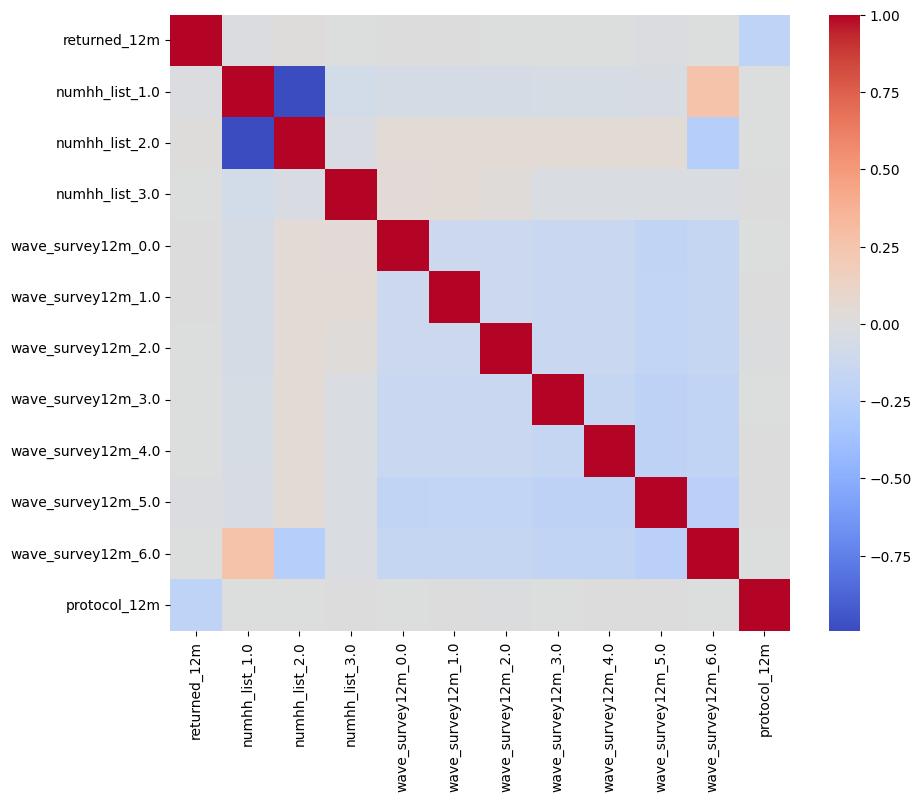

In [774]:
corr1_mat = f12m_imp_corr1.corr() #.iloc[0, :]
# focus on the first row / col

plt.figure(figsize = (10,8))
sns.heatmap(corr1_mat, cmap='coolwarm')
plt.show()
# note protocol_12m and weight_12m

In [267]:
from matplotlib.pyplot import figure

In [291]:
f12m_imp_data['returned_12m_int'] = f12m_imp_data['returned_12m'].astype(int)

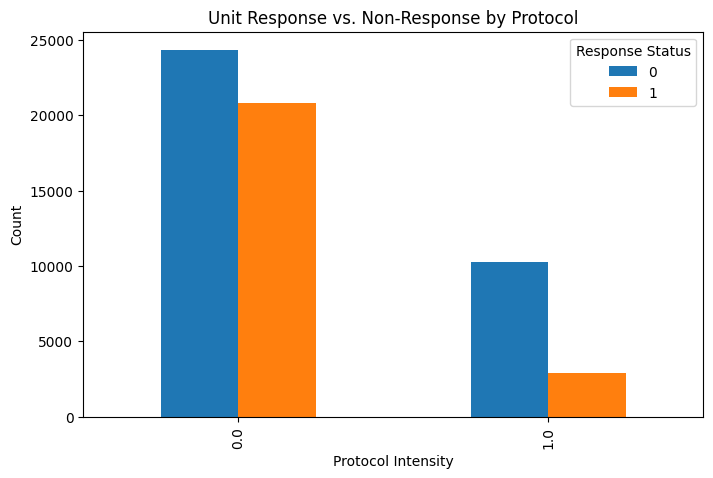

In [292]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)
pd.crosstab(f12m_imp_data.protocol_12m,f12m_imp_data.returned_12m_int).plot(kind='bar')
plt.title('Unit Response vs. Non-Response by Protocol')
plt.xlabel('Protocol Intensity')
plt.ylabel('Count')

legend = plt.legend()
legend.set_title('Response Status')

plt.savefig('just_protocol')

In [303]:
#f12m_imp_data['age'] = 2009 - f12m_imp_data['birthyear_list']

In [288]:
f12m_imp_corr2 = f12m_imp_data[['returned_12m', 'age', 'have_phone_list', 'english_list', 'female_list', 
                                'first_day_list', 'last_day_list', 'pobox_list', 'self_list', 'week_list',
                                'zip_msa_list', 'OHIE_app_ins']]

In [279]:
f12m_imp_corr2.corr().iloc[0, :]

returned_12m       1.000000
age                0.163303
have_phone_list    0.075007
english_list       0.025519
female_list        0.075366
first_day_list     0.030017
last_day_list     -0.027695
pobox_list         0.024307
self_list          0.007338
week_list         -0.048347
zip_msa_list      -0.035106
OHIE_app_ins       0.049096
Name: returned_12m, dtype: float64

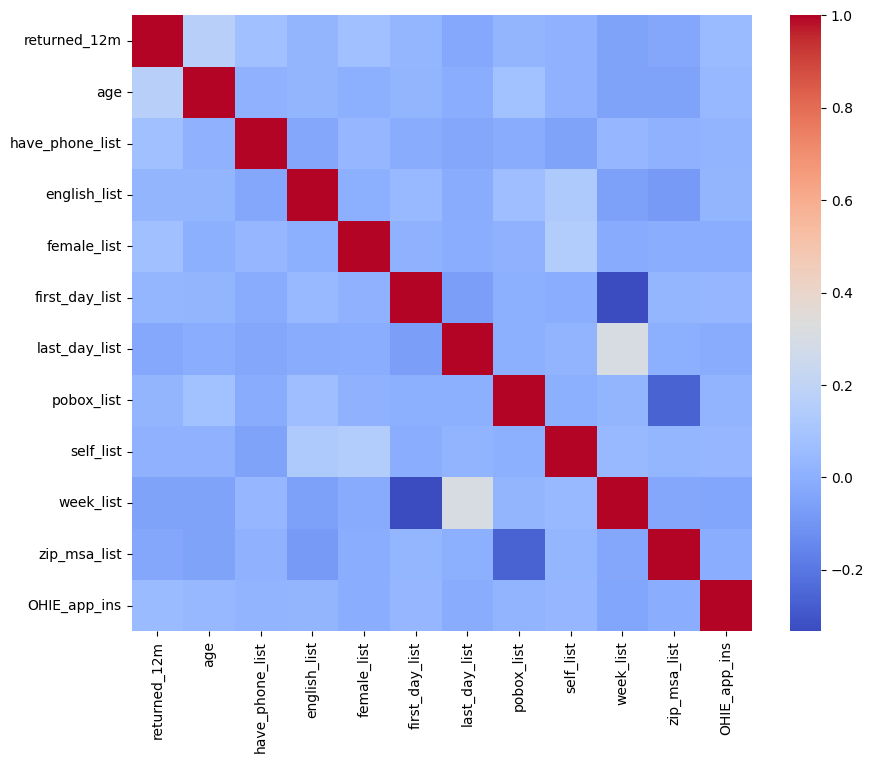

In [289]:
corr2_mat = f12m_imp_corr2.corr() #.iloc[0, :]
# focus on the first row / col

plt.figure(figsize = (10,8))
sns.heatmap(corr2_mat, cmap='coolwarm')
plt.show()
# note age

In [294]:
f12m_imp_data['age_int'] = f12m_imp_data['age'].astype(int)

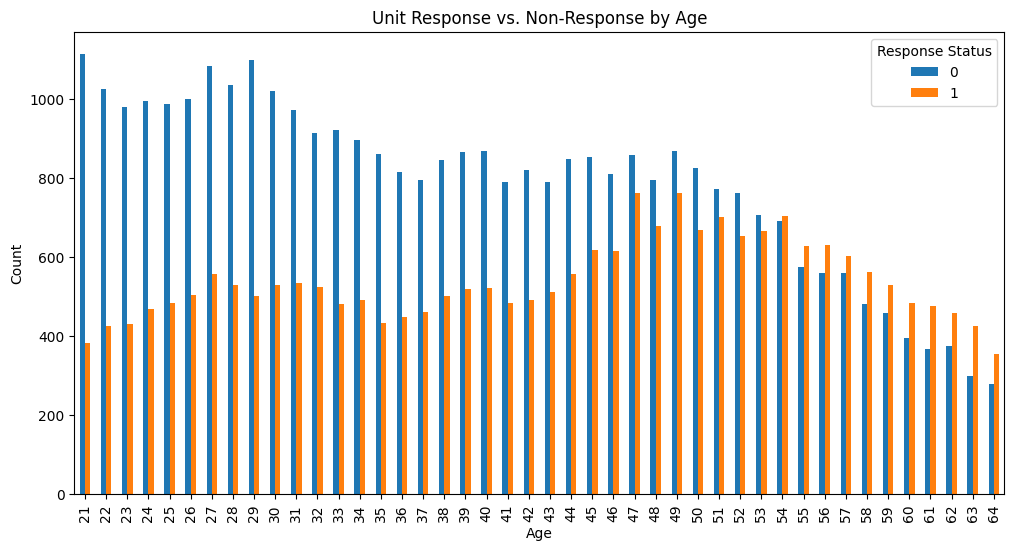

In [295]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
#plt.figure(figsize = (12,8))
pd.crosstab(f12m_imp_data.age_int,f12m_imp_data.returned_12m_int).plot(kind='bar')
plt.title('Unit Response vs. Non-Response by Age')
plt.xlabel('Age')
plt.ylabel('Count')

legend = plt.legend()
legend.set_title('Response Status')

plt.savefig('just_age')

In [296]:
f12m_imp_corr3 = f12m_imp_data[['returned_12m', 'snap_ever_prenotify07', 'snap_ever_matchn_30sep2009',
                                'snap_tot_hh_prenotify07', 'snap_tot_hh_30sep2009', 'tanf_ever_prenotify07',
                                'tanf_ever_matchn_30sep2009','tanf_tot_hh_prenotify07','tanf_tot_hh_30sep2009']]

In [297]:
f12m_imp_corr3.corr().iloc[0, :]

returned_12m                  1.000000
snap_ever_prenotify07        -0.018120
snap_ever_matchn_30sep2009    0.007340
snap_tot_hh_prenotify07      -0.021602
snap_tot_hh_30sep2009         0.003393
tanf_ever_prenotify07        -0.036117
tanf_ever_matchn_30sep2009   -0.042775
tanf_tot_hh_prenotify07      -0.025268
tanf_tot_hh_30sep2009        -0.037154
Name: returned_12m, dtype: float64

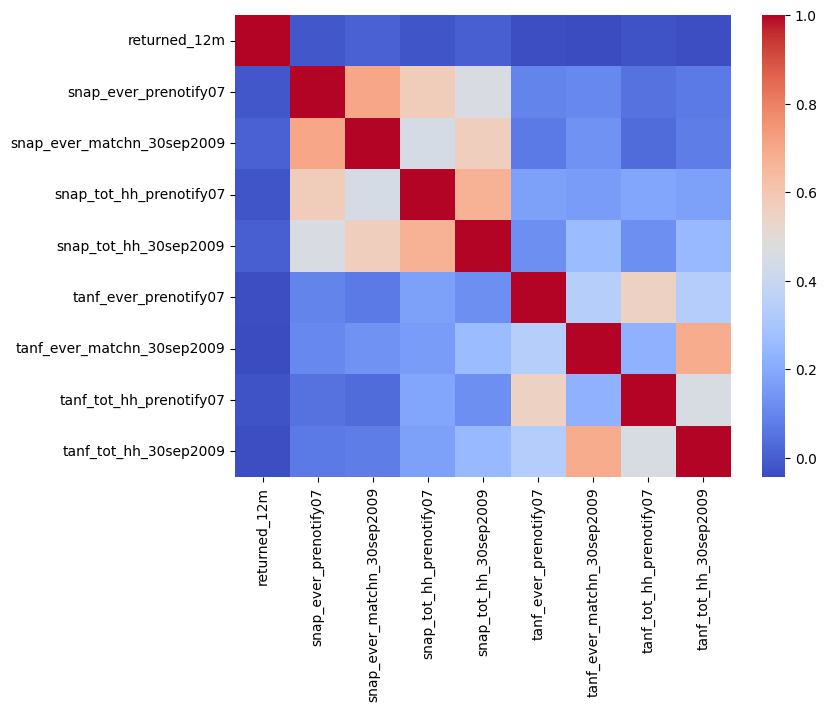

In [345]:
corr3_mat = f12m_imp_corr3.corr() #.iloc[0, :]
# focus on the first row / col

plt.figure(figsize = (8,6))
sns.heatmap(corr3_mat, cmap='coolwarm')
plt.show()
# nothing too significant here but we will see

The above procedure gives us three potential variables: protocol_12m, weight_12m and age. (Update: weight_12m not considered.)

How to identify confounding variables under a joint distribution setting? TA said that there is no good (standard) way to test for it without time. I propose this (which may or may not work): we run a random forest, which does automatic feature selection. Then we select the top few variables (i.e. those seem to predict missing values status well, thus high correlation), say $n = 5$.

*Update 02/29: can also try Lasso. Also this approach does bear the caveat of forming hypothesis based on the data that we want to apply it to, but prof said we can just mention it in the passing.*

*Update 03/03: never mind, I think we will need all the variables we can get to justify the independence assumption needed for the moment condition. But I will leave the graphs just in case they are useful later.*

*Update 03/04: I will still use a large set for $X$, but use random forest to identify a few important variables is good.*

*Update 03/07: cannot use large $X$ without justification, aim to make a graph for each*

In [456]:
# pip install scikit-learn

In [309]:
# right
X_miss = pd.DataFrame(
    f12m_imp_data[['have_phone_list', 'english_list', 'female_list', 'first_day_list', 'last_day_list', 
                   'pobox_list', 'self_list', 'week_list', 'zip_msa_list', 'OHIE_app_ins',
                   'snap_ever_prenotify07', 'snap_ever_matchn_30sep2009', 'snap_tot_hh_prenotify07', 'snap_tot_hh_30sep2009', 
                   'tanf_ever_prenotify07', 'tanf_ever_matchn_30sep2009','tanf_tot_hh_prenotify07','tanf_tot_hh_30sep2009'
                  ]])
y_miss = f12m_imp_data['returned_12m']
# first ran including 'weight_12m', 'protocol_12m', 'age'
# then exclude those because want to identify new potential variables to include with X

In [299]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import math

In [305]:
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_miss, y_miss, test_size=0.2, random_state=27)

In [306]:
Xscaler = StandardScaler().fit(X_full_train)
X_train_scaled = Xscaler.transform(X_full_train)

In [307]:
RF_full = RandomForestClassifier(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2).fit(X_train_scaled, y_full_train)

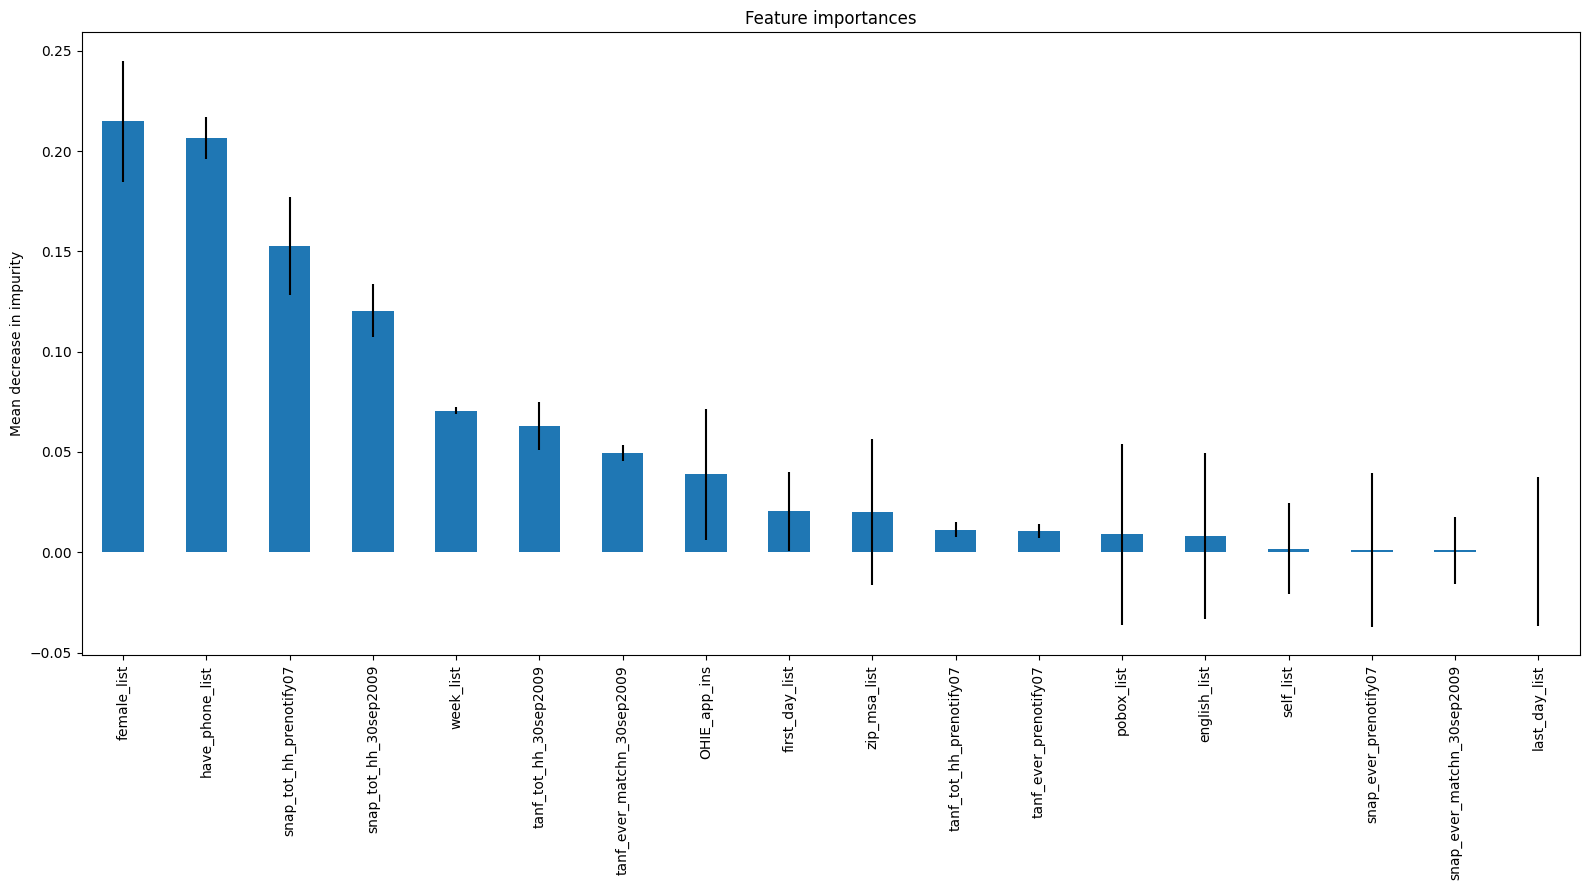

In [308]:
feature_names = X_miss.columns
importances = RF_full.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_full.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
forest_importances_sorted = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize =(16, 9))
forest_importances_sorted.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [327]:
forest_importances_sorted[:10]
# examine everything > 0.05

female_list                   0.214787
have_phone_list               0.206367
snap_tot_hh_prenotify07       0.152630
snap_tot_hh_30sep2009         0.120415
week_list                     0.070511
tanf_tot_hh_30sep2009         0.062997
tanf_ever_matchn_30sep2009    0.049506
OHIE_app_ins                  0.038945
first_day_list                0.020327
zip_msa_list                  0.020204
dtype: float64

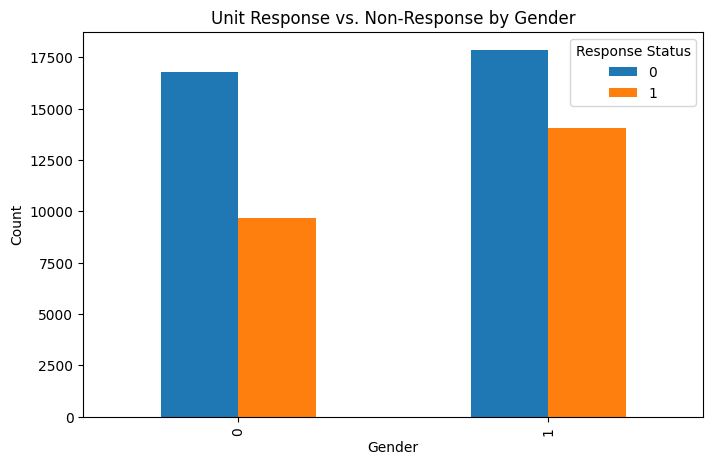

In [313]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)
#f12m_imp_data = f12m_imp_data[f12m_imp_data['female_list'] != -1]
pd.crosstab(f12m_imp_data.female_list.astype(int),f12m_imp_data.returned_12m_int).plot(kind='bar')
plt.title('Unit Response vs. Non-Response by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

legend = plt.legend()
legend.set_title('Response Status')

plt.savefig('just_gender')

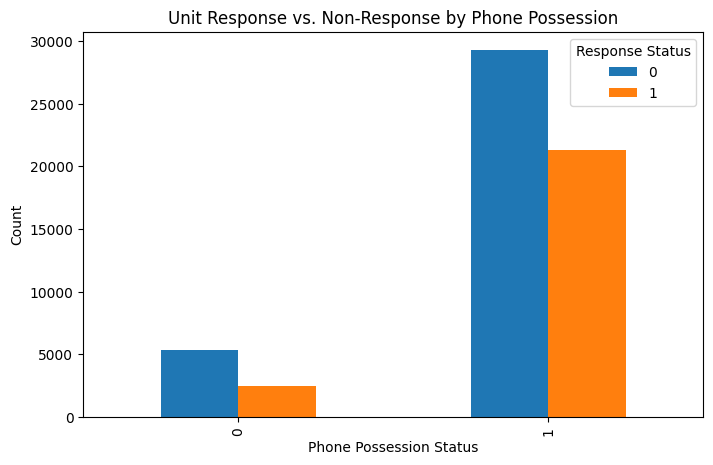

In [317]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)
pd.crosstab(f12m_imp_data.have_phone_list.astype(int),f12m_imp_data.returned_12m_int).plot(kind='bar')
plt.title('Unit Response vs. Non-Response by Phone Possession')
plt.xlabel('Phone Possession Status')
plt.ylabel('Count')

legend = plt.legend()
legend.set_title('Response Status')

plt.savefig('just_phone')

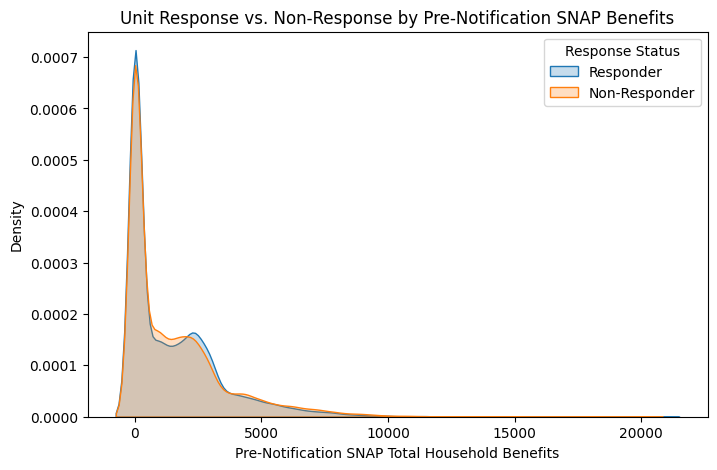

<Figure size 800x500 with 0 Axes>

In [337]:
plt.figure(figsize=(8, 5))

sns.kdeplot(f12m_imp_data[f12m_imp_data['returned_12m_int'] == 1]['snap_tot_hh_prenotify07'], label='Responder', fill=True)
sns.kdeplot(f12m_imp_data[f12m_imp_data['returned_12m_int'] == 0]['snap_tot_hh_prenotify07'], label='Non-Responder', fill=True)

plt.xlabel('Pre-Notification SNAP Total Household Benefits')
plt.ylabel('Density')
plt.title('Unit Response vs. Non-Response by Pre-Notification SNAP Benefits')

legend = plt.legend()
legend.set_title('Response Status')

plt.show()
plt.savefig('just_pre_snap')

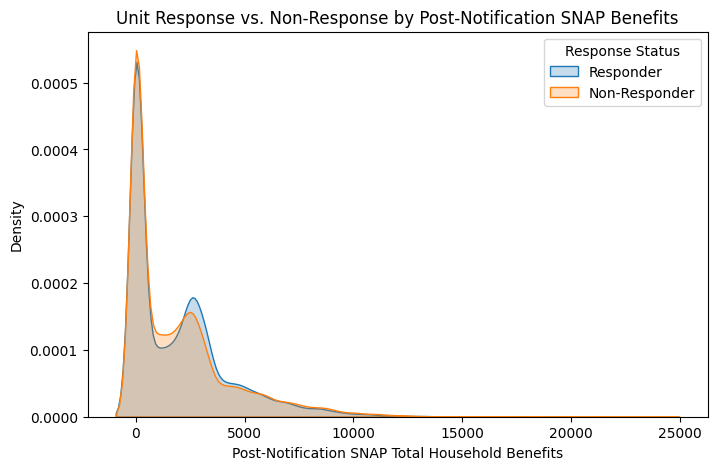

<Figure size 800x500 with 0 Axes>

In [338]:
plt.figure(figsize=(8, 5))

sns.kdeplot(f12m_imp_data[f12m_imp_data['returned_12m_int'] == 1]['snap_tot_hh_30sep2009'], label='Responder', fill=True)
sns.kdeplot(f12m_imp_data[f12m_imp_data['returned_12m_int'] == 0]['snap_tot_hh_30sep2009'], label='Non-Responder', fill=True)

plt.xlabel('Post-Notification SNAP Total Household Benefits')
plt.ylabel('Density')
plt.title('Unit Response vs. Non-Response by Post-Notification SNAP Benefits')

legend = plt.legend()
legend.set_title('Response Status')

plt.show()
plt.savefig('just_post_snap')

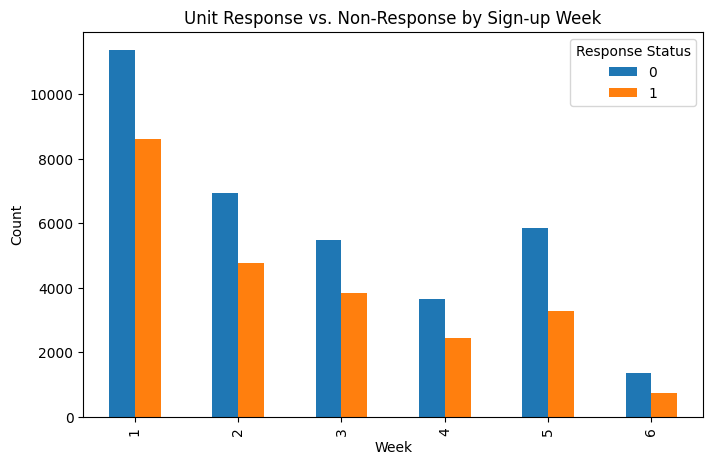

In [326]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)
#f12m_imp_data = f12m_imp_data[f12m_imp_data['female_list'] != -1]
pd.crosstab(f12m_imp_data.week_list.astype(int)+1,f12m_imp_data.returned_12m_int).plot(kind='bar')
plt.title('Unit Response vs. Non-Response by Sign-up Week')
plt.xlabel('Week')
plt.ylabel('Count')

legend = plt.legend()
legend.set_title('Response Status')

plt.savefig('just_week')

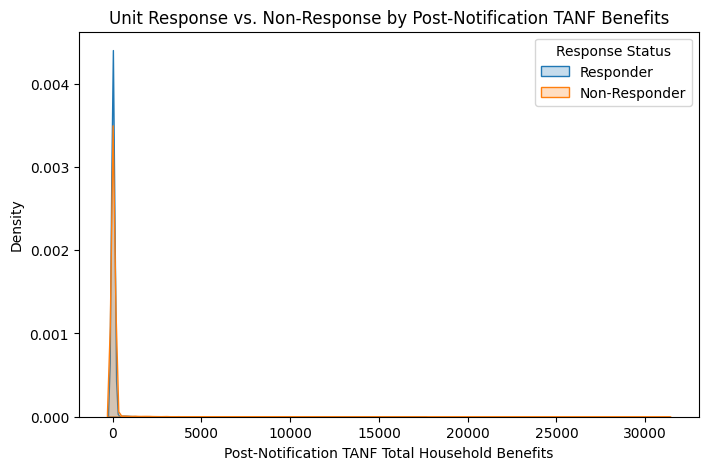

<Figure size 800x500 with 0 Axes>

In [339]:
plt.figure(figsize=(8, 5))

sns.kdeplot(f12m_imp_data[f12m_imp_data['returned_12m_int'] == 1]['tanf_tot_hh_30sep2009'], label='Responder', fill=True)
sns.kdeplot(f12m_imp_data[f12m_imp_data['returned_12m_int'] == 0]['tanf_tot_hh_30sep2009'], label='Non-Responder', fill=True)

plt.xlabel('Post-Notification TANF Total Household Benefits')
plt.ylabel('Density')
plt.title('Unit Response vs. Non-Response by Post-Notification TANF Benefits')

legend = plt.legend()
legend.set_title('Response Status')

plt.show()
plt.savefig('just_post_tanf')

I know the graphs for the continuous variables do not seem like they exhibit much difference between responder and non-responder trends, but there is some variation in the middle for all three, and I think that is sufficiently good basis for including them.

In [769]:
f12m_imp_corr4 = f12m_imp_data[['protocol_12m', 'age', 'female_list', 'have_phone_list', 'snap_tot_hh_prenotify07',
                  'snap_tot_hh_30sep2009', 'week_list', 'tanf_tot_hh_30sep2009']]

In [770]:
corr4_mat = f12m_imp_corr4.corr() #.iloc[0, :]
corr4_mat

,protocol_12m,age,female_list,have_phone_list,snap_tot_hh_prenotify07,snap_tot_hh_30sep2009,week_list,tanf_tot_hh_30sep2009
protocol_12m,1.000000,-0.072375,-0.028064,-0.008217,0.014713,0.003042,0.019669,0.017105
age,-0.072375,1.000000,0.004286,0.010667,-0.074335,-0.100194,-0.048965,-0.073539
female_list,-0.028064,0.004286,1.000000,0.032378,0.061677,0.050863,-0.020288,0.065172
have_phone_list,-0.008217,0.010667,0.032378,1.000000,0.028203,0.038913,0.032117,0.001928
snap_tot_hh_prenotify07,0.014713,-0.074335,0.061677,0.028203,1.000000,0.670736,-0.050488,0.169907
snap_tot_hh_30sep2009,0.003042,-0.100194,0.050863,0.038913,0.670736,1.000000,-0.042472,0.254147
week_list,0.019669,-0.048965,-0.020288,0.032117,-0.050488,-0.042472,1.000000,-0.004406
tanf_tot_hh_30sep2009,0.017105,-0.073539,0.065172,0.001928,0.169907,0.254147,-0.004406,1.000000


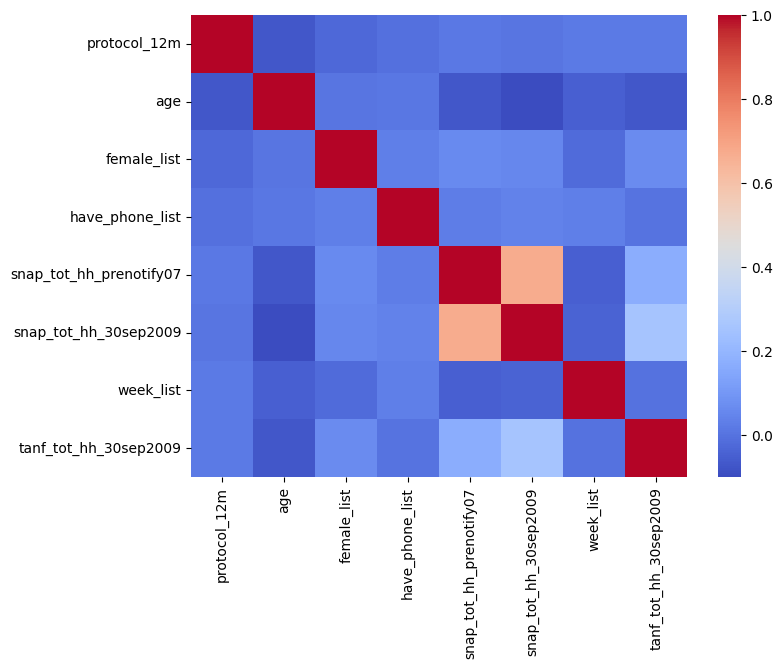

In [771]:
plt.figure(figsize = (8,6))
sns.heatmap(corr4_mat, cmap='coolwarm')
plt.show()
# only (protocol_12m, weight_12m) and (pre_snap, post_snap) are decently correlated

Note that these 8 variables make sense: protocol intensity, age, gender, electronic possession, previous activity in the lottery (week-up list), and socioeconomic status (which correlates with various status on governmental programs) should all correlate with response rate and health and financial outcomes. How to justify whether these variables account for sufficient correlation such that the corresponding independence assumption hold? Well, the math behind (check the proof document) gives us two sets of propensity scores for the missing indicator $S$ - one dependent on $X$ and the other on $X$ and $W$. If the independence assumption truly holds, using either set of propensity scores in our estimation function should not yield much difference. So this is the first crucial check we will be conducting in the next section. 

Otherwise, note that the two SNAP variables are highly correlated, so another thing we can do is to remove one of them (say the 'prenotify' one) out of the $X$ set and see if the above still hold. If yes, I will go with the 7-variable set instead of the 8-variable set for $X$, but otherwise I don't see a reason to reduce/expand this set that we already have here.

## Part 4: LATE Estimation Function \& Parameter Selection

In this section, I started constructing the LATE estimation function according to the derived Neyman orthogonal score function (please see main paper). I decided to use random forest to estimate each nuisance parameter. The parameters are selected by running each forest on a train-validation-test set for one outcome. This is obviously not ideal, but considering the time constraint and computational feasibility it was all what we could do.

I initially ran the random forests across 'n_estimators' (number of trees), 'max_feature' and 'max_depth', with three values for each. Later on I was forced to use 'n_estimators = 100' for all forest to shorten computational length.

In [3]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [4]:
outcome1 = ['rx_any_12m', 'rx_num_mod_12m', 'doc_any_12m', 'doc_num_mod_12m', 
             'er_any_12m', 'er_num_mod_12m', 'hosp_any_12m' , 'hosp_num_mod_12m']

outcome2 = ['cost_any_oop_12m', 'cost_any_owe_12m', 'cost_borrow_12m', 'cost_refused_12m'] 
# 'cost_tot_oop_12m''cost_tot_owe_12m', 

outcome3 = ['neg_health_gen_bin_12m', 'neg_health_chg_bin_12m', 'gooddays_phys_12m','gooddays_ment_12m',
            'neg_health_work_12m', 'neg_dep_indc'] 

outcome4 = ['usual_clinic_12m', 'usual_doc_12m', 'needmet_med_cor_12m', 'needmet_rx_cor_12m', 
            'ner_noner_12m', 'med_qual_bin_12m', 'neg_happiness_12m'] 

outcomes = outcome1 + outcome2 + outcome3 + outcome4

In [5]:
W = ['numhh_list_1.0', 'numhh_list_2.0', 'numhh_list_3.0', 'wave_survey12m_0.0', 'wave_survey12m_1.0',
     'wave_survey12m_2.0', 'wave_survey12m_3.0', 'wave_survey12m_4.0', 'wave_survey12m_5.0', 'wave_survey12m_6.0',
     'numhh_wave_intcat_1.0:0.0', 'numhh_wave_intcat_1.0:1.0', 'numhh_wave_intcat_1.0:2.0', 'numhh_wave_intcat_1.0:3.0',
     'numhh_wave_intcat_1.0:4.0', 'numhh_wave_intcat_1.0:5.0', 'numhh_wave_intcat_1.0:6.0', 'numhh_wave_intcat_2.0:0.0',
     'numhh_wave_intcat_2.0:1.0', 'numhh_wave_intcat_2.0:2.0', 'numhh_wave_intcat_2.0:3.0', 'numhh_wave_intcat_2.0:4.0',
     'numhh_wave_intcat_2.0:5.0', 'numhh_wave_intcat_2.0:6.0', 'numhh_wave_intcat_3.0:0.0', 'numhh_wave_intcat_3.0:1.0',
     'numhh_wave_intcat_3.0:2.0']

In [6]:
X1 = ['weight_12m']

In [7]:
X = ['protocol_12m', 'age', 'female_list', 'have_phone_list', 'snap_tot_hh_prenotify07',
     'snap_tot_hh_30sep2009', 'week_list', 'tanf_tot_hh_30sep2009']

In [8]:
X_alt = ['protocol_12m', 'age', 'female_list', 'have_phone_list', 'snap_tot_hh_30sep2009', 'week_list', 'tanf_tot_hh_30sep2009']

In [9]:
X_all = ['have_phone_list', 'english_list', 'female_list', 'first_day_list','last_day_list',
         'pobox_list', 'self_list', 'week_list', 'zip_msa_list', 'OHIE_app_ins', 'age',
         'snap_ever_prenotify07', 'snap_ever_matchn_30sep2009', 'snap_tot_hh_prenotify07', 'snap_tot_hh_30sep2009',
         'tanf_ever_prenotify07', 'tanf_ever_matchn_30sep2009', 'tanf_tot_hh_prenotify07', 'tanf_tot_hh_30sep2009',
         'weight_intensive_12m', 'protocol_12m']
# just in case

In [10]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [11]:
from sklearn.preprocessing import StandardScaler

In [18]:
#W = controls
#X = ['intproto_indc', 'age', 'snap_tot_hh_prenotify07', 'snap_tot_hh_30sep2009', 'zip_msa_indc']
Z_b = ['treatment']
D_b = ['ohp_all_ever_matchn_30sep2009']
S_b = ['returned_12m']
Y_b = ['rx_any_12m']

rx_any_vars = W + X_alt + Z_b + D_b + S_b + Y_b
rx_any_data = f12m_imp_data[rx_any_vars]

Z = 'treatment'
D = 'ohp_all_ever_matchn_30sep2009'
S = 'returned_12m'
Y = 'rx_any_12m'

NameError: name 'f12m_imp_data' is not defined

In [12]:
def get_tau(Y, D, Z, S, r, q, a1, a0, b1, b0, f1, f0, g1, g0):
    g11 = (Y*Z*S)/ (r*q) - (Z - r)*a1/(r*r) - (S - q)*b1/(r*q)
    g10 = (Y*(1-Z)*S)/((1-r)*q) - (Z - r)*a0/((1-r)*(1-r)) - (S - q)*b0/((1-r)*q)
    g21 = (D*Z*S)/(r*q) - (Z - r)*f1/(r*r) - (S - q)*g1/(r*q)
    g20 = (D*(1-Z)*S)/((1-r)*q) - (Z - r)*f0/((1-r)*(1-r)) - (S - q)*g0/((1-r)*q)
    
    return np.mean(g11 - g10) / np.mean(g21 - g20)

In [1022]:
data = rx_any_data 

In [944]:
# run the whole thing outside once for 1 variable for parameter selection
# obviously not ideal, but given the time constraint ... 
nfolds = 2
param_list = []
kf = KFold(n_splits=nfolds, shuffle=True, random_state=27)
tau1_vec = []
tau2_vec = []

In [960]:
#for train_index, test_index in kf.split(data):
sub_list = []

train_data = data.iloc[train_index]
test_data = data.iloc[test_index]

In [961]:
train_data.shape

(38912, 38)

In [962]:
test_data.shape

(19457, 38)

In [1023]:
# need to scale data
train_data = data.iloc[train_index]
test_data = data.iloc[test_index]
Y_train = train_data[[Y]]
Y_test = test_data[[Y]]
ftrain_data = train_data[train_data[S] == 1]

In [972]:
# Predict r(W) 
r_model = RandomForestClassifier(random_state = 27)
r_best = GridSearchCV(r_model, n_jobs = -1, verbose = 1, 
                      param_grid = {'n_estimators': [100], 
                                    'max_features': [5, 10, 20],
                                    'max_depth': [3, 5, 7],
                                    'min_samples_leaf': [2]})
r_best.fit(train_data[W], train_data[Z])
r_pred = r_best.predict_proba(test_data[W])[:,1]
r_pred[r_pred == 0] = 1e-6

r_best.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 100}

In [974]:
# Predict q1(X) 
q1_model = RandomForestClassifier(random_state = 27)
q1_best = GridSearchCV(q1_model, n_jobs = -1, verbose = 1, 
                      param_grid = {'n_estimators': [100],
                                    'max_features': [5, 10, 20],
                                    'max_depth': [3, 5, 7],
                                    'min_samples_leaf': [2]})
q1_best.fit(train_data[X_alt], train_data[S])
q1_pred = q1_best.predict_proba(test_data[X_alt])[:,1]
q1_pred[q1_pred == 0] = 1e-6

q1_best.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 100}

In [975]:
# Predict q2(X,W) 
q2_model = RandomForestClassifier(random_state = 27)
q2_best = GridSearchCV(q2_model, n_jobs = -1, verbose = 1, 
                      param_grid = {'n_estimators': [100],
                                    'max_features': [5, 10, 20],
                                    'max_depth': [3, 5, 7],
                                    'min_samples_leaf': [2]})
q2_best.fit(train_data[X_alt + W], train_data[S])
q2_pred = q2_best.predict_proba(test_data[X_alt + W])[:,1]
q2_pred[q2_pred == 0] = 1e-6

q2_best.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'max_depth': 7,
 'max_features': 20,
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [977]:
# Predict a1(W)
a1_model = RandomForestRegressor(random_state = 27)
a1_best = GridSearchCV(a1_model, n_jobs = -1, verbose = 1, 
                      param_grid = {'n_estimators': [100],
                                    'max_features': [5, 10, 20],
                                    'max_depth': [3, 5, 7],
                                    'min_samples_leaf': [2]})
a1_best.fit(ftrain_data[W], ftrain_data[Y] * ftrain_data[Z])
a1_pred = a1_best.predict(ftest_data[W])

a1_best.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'max_depth': 5,
 'max_features': 20,
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [978]:
# Predict a0(W)
a0_model = RandomForestRegressor(random_state = 27)
a0_best = GridSearchCV(a0_model, n_jobs = -1, verbose = 1, 
                      param_grid = {'n_estimators': [100],
                                    'max_features': [5, 10, 20],
                                    'max_depth': [3, 5, 7],
                                    'min_samples_leaf': [2]})
a0_best.fit(ftrain_data[W], ftrain_data[Y])
a0_pred = a0_best.predict(ftest_data[W]) - a1_pred

a0_best.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'max_depth': 3,
 'max_features': 10,
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [980]:
# Predict b1(W)
b1_model = RandomForestRegressor(random_state = 27)
b1_best = GridSearchCV(b1_model, n_jobs = -1, verbose = 1, 
                      param_grid = {'n_estimators': [100],
                                    'max_features': [5, 10, 20],
                                    'max_depth': [3, 5, 7],
                                    'min_samples_leaf': [2]})
b1_best.fit(ftrain_data[X_alt + W], ftrain_data[Y] * ftrain_data[Z])
b1_pred = b1_best.predict(ftest_data[X_alt + W])

b1_best.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'max_depth': 7,
 'max_features': 20,
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [981]:
# Predict b0(W)
b0_model = RandomForestRegressor(random_state=27)
b0_best = GridSearchCV(b0_model, n_jobs = -1, verbose = 1, 
                      param_grid = {'n_estimators': [100],
                                    'max_features': [5, 10, 20],
                                    'max_depth': [3, 5, 7],
                                    'min_samples_leaf': [2]})
b0_best.fit(ftrain_data[X_alt + W], ftrain_data[Y])
b0_pred = b0_best.predict(ftest_data[X_alt + W]) - b1_pred

b0_best.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'max_depth': 5,
 'max_features': 20,
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [982]:
# Predict f1(W)
f1_model = RandomForestClassifier(random_state = 27)
f1_best = GridSearchCV(f1_model, n_jobs = -1, verbose = 1, 
                      param_grid = {'n_estimators': [100],
                                    'max_features': [5, 10, 20],
                                    'max_depth': [3, 5, 7],
                                    'min_samples_leaf': [2]})
f1_best.fit(ftrain_data[W], ftrain_data[D] * ftrain_data[Z])
f1_pred = f1_best.predict_proba(ftest_data[W])[:,1]
f1_pred[f1_pred == 0] = 1e-6

f1_best.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 100}

In [983]:
# Predict f0(W)
f0_model = RandomForestClassifier(random_state = 27)
f0_best = GridSearchCV(f0_model, n_jobs = -1, verbose = 1, 
                      param_grid = {'n_estimators': [100],
                                    'max_features': [5, 10, 20],
                                    'max_depth': [3, 5, 7],
                                    'min_samples_leaf': [2]})
f0_best.fit(ftrain_data[W], ftrain_data[D])
f0_pred = f0_best.predict_proba(ftest_data[W])[:,1] - f1_pred
f0_pred[f0_pred == 0] = 1e-6

f0_best.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 100}

In [984]:
# Predict g1(W)
g1_model = RandomForestClassifier(random_state = 27)
g1_best = GridSearchCV(g1_model, n_jobs = -1, verbose = 1, 
                      param_grid = {'n_estimators': [100],
                                    'max_features': [5, 10, 20],
                                    'max_depth': [3, 5, 7],
                                    'min_samples_leaf': [2]})
g1_best.fit(ftrain_data[X_alt + W], ftrain_data[D] * ftrain_data[Z])
g1_pred = g1_best.predict_proba(ftest_data[X_alt + W])[:,1]
g1_pred[g1_pred == 0] = 1e-6

g1_best.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'max_depth': 7,
 'max_features': 20,
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [986]:
# Predict g0(W)
g0_model1 = RandomForestClassifier(random_state = 27)
g0_best1 = GridSearchCV(g0_model1, n_jobs = -1, verbose = 1, 
                      param_grid = {'n_estimators': [100],
                                    'max_features': [5, 10, 20],
                                    'max_depth': [3, 5, 7],
                                    'min_samples_leaf': [2]})
g0_best1.fit(ftrain_data[X_alt + W], ftrain_data[D])
g0_pred1 = g0_best1.predict_proba(ftest_data[X_alt + W])[:,1] - g1_pred
g0_pred1[g0_pred1 == 0] = 1e-6

g0_best1.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'max_depth': 7,
 'max_features': 20,
 'min_samples_leaf': 2,
 'n_estimators': 100}

Now we combine everything into one function.

**Note: the function 'dml_tau_est1' in the original notebook has a major error from one of the variables not being scaled. This has now being corrected. Please find the updated estimates in Updated Tables Table 2.**

In [13]:
# right version, use this
def dml_tau_est1(data, W, X, Z, D, S, Y, nj = 2, nfolds=5):
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=27)
    tau1_vec = []
    tau2_vec = []
    
    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        ftrain_data = train_data[train_data[S] == 1]
        
        # Predict r(W) 
        r_model = RandomForestClassifier(n_estimators=100, max_features=5, max_depth=5, min_samples_leaf=2, 
                                         n_jobs = nj, random_state=27)
        r_model.fit(train_data[W], train_data[Z])
        r_pred = r_model.predict_proba(test_data[W])[:,1]
        r_pred[r_pred == 0] = 1e-6

        # Predict q1(X) 
        q1_model = RandomForestClassifier(n_estimators=100, max_features=5, max_depth=7, min_samples_leaf=2,
                                          n_jobs = nj, random_state=27)
        q1_model.fit(train_data[X], train_data[S])
        q1_pred = q1_model.predict_proba(test_data[X])[:,1]
        q1_pred[q1_pred == 0] = 1e-6

        # Predict q2(X,W) 
        q2_model = RandomForestClassifier(n_estimators=100, max_features=20, max_depth=7, min_samples_leaf=2, 
                                          n_jobs = nj, random_state=27)
        q2_model.fit(train_data[X + W], train_data[S])
        q2_pred = q2_model.predict_proba(test_data[X + W])[:,1]
        q2_pred[q2_pred == 0] = 1e-6
        
        # Predict a1(W)
        a1_model = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=35, min_samples_leaf=2, 
                                         n_jobs = nj, random_state=27)
        a1_model.fit(ftrain_data[W], ftrain_data[Y] * ftrain_data[Z])
        a1_pred = a1_model.predict(test_data[W])
        
        # Predict a0(W)
        a0_model = RandomForestRegressor(n_estimators=100, max_features=10, max_depth=3, min_samples_leaf=2, 
                                         n_jobs = nj, random_state=27)
        a0_model.fit(ftrain_data[W], ftrain_data[Y])
        a0_pred = a0_model.predict(test_data[W]) - a1_pred

        # Predict b1(W)
        b1_model = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=7, min_samples_leaf=2, 
                                         n_jobs = nj, random_state=27)
        b1_model.fit(ftrain_data[X + W], ftrain_data[Y] * ftrain_data[Z])
        b1_pred = b1_model.predict(test_data[X + W])
        
        # Predict b0(W)
        b0_model = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2, 
                                         n_jobs = nj, random_state=27)
        b0_model.fit(ftrain_data[X + W], ftrain_data[Y])
        b0_pred = b0_model.predict(test_data[X + W]) - b1_pred

        # Predict f1(W)
        f1_model = RandomForestClassifier(n_estimators=100, max_features=5, max_depth=3, min_samples_leaf=2, 
                                          n_jobs = nj, random_state=27)
        f1_model.fit(ftrain_data[W], ftrain_data[D] * ftrain_data[Z])
        f1_pred = f1_model.predict_proba(test_data[W])[:,1]
        f1_pred[f1_pred == 0] = 1e-6

        # Predict f0(W)
        f0_model = RandomForestClassifier(n_estimators=100, max_features=5, max_depth=3, min_samples_leaf=2, 
                                          n_jobs = nj, random_state=27)
        f0_model.fit(ftrain_data[W], ftrain_data[D])
        f0_pred = f0_model.predict_proba(test_data[W])[:,1] - f1_pred
        f0_pred[f0_pred == 0] = 1e-6
        
        # Predict g1(W)
        g1_model = RandomForestClassifier(n_estimators=100, max_features=20, max_depth=7, min_samples_leaf=2, 
                                          n_jobs = nj, random_state=27)
        g1_model.fit(ftrain_data[X + W], ftrain_data[D] * ftrain_data[Z])
        g1_pred = g1_model.predict_proba(test_data[X + W])[:,1]
        g1_pred[g1_pred == 0] = 1e-6

        # Predict g0(W)
        g0_model = RandomForestClassifier(n_estimators=100, max_features=20, max_depth=7, min_samples_leaf=2, 
                                          n_jobs = nj, random_state=27)
        g0_model.fit(ftrain_data[X + W], ftrain_data[D])
        g0_pred = g0_model.predict_proba(test_data[X + W])[:,1] - g1_pred
        g0_pred[g0_pred == 0] = 1e-6


        test_data.loc[test_data[S] == 0, Y] = 0

        tau1 = get_tau(test_data[Y], test_data[D], test_data[Z], test_data[S], 
                       r_pred, q1_pred, a1_pred, a0_pred, b1_pred, b0_pred, f1_pred, f0_pred, g1_pred, g0_pred)
        tau2 = get_tau(test_data[Y], test_data[D], test_data[Z], test_data[S], 
                       r_pred, q2_pred, a1_pred, a0_pred, b1_pred, b0_pred, f1_pred, f0_pred, g1_pred, g0_pred)

        tau1_vec.append(tau1)
        tau2_vec.append(tau2)

    return np.mean(tau1_vec), np.mean(tau2_vec)

## Part 5: Testing LATE Function \& Initial Tests

In [988]:
# some repeated codes here so I don't have to scroll all the way up
W = ['numhh_list_1.0', 'numhh_list_2.0', 'numhh_list_3.0', 'wave_survey12m_0.0', 'wave_survey12m_1.0',
     'wave_survey12m_2.0', 'wave_survey12m_3.0', 'wave_survey12m_4.0', 'wave_survey12m_5.0', 'wave_survey12m_6.0',
     'numhh_wave_intcat_1.0:0.0', 'numhh_wave_intcat_1.0:1.0', 'numhh_wave_intcat_1.0:2.0', 'numhh_wave_intcat_1.0:3.0',
     'numhh_wave_intcat_1.0:4.0', 'numhh_wave_intcat_1.0:5.0', 'numhh_wave_intcat_1.0:6.0', 'numhh_wave_intcat_2.0:0.0',
     'numhh_wave_intcat_2.0:1.0', 'numhh_wave_intcat_2.0:2.0', 'numhh_wave_intcat_2.0:3.0', 'numhh_wave_intcat_2.0:4.0',
     'numhh_wave_intcat_2.0:5.0', 'numhh_wave_intcat_2.0:6.0', 'numhh_wave_intcat_3.0:0.0', 'numhh_wave_intcat_3.0:1.0',
     'numhh_wave_intcat_3.0:2.0']

In [1018]:
X = ['protocol_12m', 'age', 'female_list', 'have_phone_list', 'snap_tot_hh_prenotify07',
     'snap_tot_hh_30sep2009', 'week_list', 'tanf_tot_hh_30sep2009']

In [990]:
X1 = ['weight_12m']

In [1019]:
# some test runs to determine X
Z_b = ['treatment']
D_b = ['ohp_all_ever_matchn_30sep2009']
S_b = ['returned_12m']
Y_b = ['rx_any_12m']

rx_any_vars = W + X + Z_b + D_b + S_b + Y_b
rx_any_data = f12m_imp_data[rx_any_vars]

Z = 'treatment'
D = 'ohp_all_ever_matchn_30sep2009'
S = 'returned_12m'
Y = 'rx_any_12m'

In [992]:
outcome1 = ['rx_any_12m', 'rx_num_mod_12m', 'doc_any_12m', 'doc_num_mod_12m', 
             'er_any_12m', 'er_num_mod_12m', 'hosp_any_12m' , 'hosp_num_mod_12m']

outcome2 = ['cost_any_oop_12m', 'cost_any_owe_12m', 'cost_borrow_12m', 'cost_refused_12m'] 
# 'cost_tot_oop_12m''cost_tot_owe_12m', 

outcome3 = ['neg_health_gen_bin_12m', 'neg_health_chg_bin_12m', 'gooddays_phys_12m','gooddays_ment_12m',
            'neg_health_work_12m', 'neg_dep_indc'] 

outcome4 = ['usual_clinic_12m', 'usual_doc_12m', 'needmet_med_cor_12m', 'needmet_rx_cor_12m', 
            'ner_noner_12m', 'med_qual_bin_12m', 'neg_happiness_12m'] 

outcomes = outcome1 + outcome2 + outcome3 + outcome4

In [1028]:
rx_any_tau1, rx_any_tau2 = dml_tau_est1(rx_any_data, W, X, Z, D, S, Y, nfolds=5)

In [1030]:
rx_any_tau1
# -0.005291468174389274
rx_any_tau2
# -0.006336338096792562
# ... 
# this may or may not be significant depending on standard errors

-0.006336338096792562

In [1031]:
# let's test the 7-variable set
X_alt = ['protocol_12m', 'age', 'female_list', 'have_phone_list',
     'snap_tot_hh_30sep2009', 'week_list', 'tanf_tot_hh_30sep2009']

rx_any_vars = W + X_alt + Z_b + D_b + S_b + Y_b
rx_any_data = f12m_imp_data[rx_any_vars]

In [1032]:
rx_any_tau3, rx_any_tau4 = dml_tau_est1(rx_any_data, W, X_alt, Z, D, S, Y, nfolds=5)

In [1034]:
rx_any_tau3
# -0.009008139053769224
rx_any_tau4 
# -0.010342903931609956

-0.010342903931609956

In [1035]:
# I am not sure what to make of the above, so let's try another outcome
Y_b = ['doc_any_12m']
Y = 'doc_any_12m'

doc_any_vars = W + X + Z_b + D_b + S_b + Y_b
doc_any_data = f12m_imp_data[doc_any_vars]

In [1036]:
doc_any_tau1, doc_any_tau2 = dml_tau_est1(doc_any_data, W, X, Z, D, S, Y, nfolds=5)

In [1039]:
doc_any_tau1
# 0.16068181669101675
doc_any_tau2
# 0.16035573634117056

0.16035573634117056

In [1041]:
doc_any_vars = W + X_alt + Z_b + D_b + S_b + Y_b
doc_any_data = f12m_imp_data[doc_any_vars]

In [1042]:
doc_any_tau3, doc_any_tau4 = dml_tau_est1(doc_any_data, W, X_alt, Z, D, S, Y, nfolds=5)

In [1044]:
doc_any_tau3
# 0.1578355569003039
doc_any_tau4
# 0.1556135068911289
# parfait
# okay so maybe still the 8-variable set

0.1556135068911289

## Part 6: Coefficient Results for our chosen $X$

In [1046]:
#outcomes
our_coeff_df = pd.DataFrame()

In [1047]:
for y in outcomes:
    Y_b = [y]
    vars = W + X + Z_b + D_b + S_b + Y_b
    data = f12m_imp_data[vars]
    Y = y
    
    tau1, tau2 = dml_tau_est1(data, W, X, Z, D, S, Y, nfolds=5)
    
    temp = pd.DataFrame([tau1, tau2]).T
    our_coeff_df = pd.concat([our_coeff_df, temp], axis = 0)

our_coeff_df.columns = ['prop_score_X', 'prop_score_XW'] 

/var/folders/dc/j_9rc1xd6xj5836y93540spc0000gn/T/ipykernel_18310/304184425.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_data.loc[test_data[S] == 0, Y] = 0
/var/folders/dc/j_9rc1xd6xj5836y93540spc0000gn/T/ipykernel_18310/304184425.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_data.loc[test_data[S] == 0, Y] = 0
/var/folders/dc/j_9rc1xd6xj5836y93540spc0000gn/T/ipykernel_18310/304184425.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_data.loc[test_data[S] == 0, Y] = 0
/var/fo

In [1048]:
#coeff_df_copy = coeff_df
#our_coeff_df_copy = our_coeff_df
#our_coeff_df_copy1 = our_coeff_df
#our_coeff_df_copy2 = our_coeff_df
#our_coeff_df_copy3 = our_coeff_df
#new_index = np.arange(0, 24)
our_coeff_df1 = our_coeff_df.reset_index(drop=True)

In [1049]:
cour_coeff_df = pd.concat([pd.DataFrame(outcomes), our_coeff_df1], axis=1)
cour_coeff_df
#ccoeff_df

,0,prop_score_X,prop_score_XW
0,rx_any_12m,-0.005291,-0.006336
1,rx_num_mod_12m,-0.039476,-0.054675
2,doc_any_12m,0.160682,0.160356
3,doc_num_mod_12m,0.746657,0.746614
4,er_any_12m,0.001227,0.001164
5,er_num_mod_12m,-0.015888,-0.015551
6,hosp_any_12m,0.019356,0.019613
7,hosp_num_mod_12m,0.031318,0.031322
8,cost_any_oop_12m,-0.233381,-0.234734
9,cost_any_owe_12m,-0.222351,-0.222084


In [1050]:
lat_our_coeff_df = cour_coeff_df.to_latex(index=True)

In [1051]:
print(lat_our_coeff_df)

\begin{tabular}{llrr}
\toprule
 & 0 & prop_score_X & prop_score_XW \\
\midrule
0 & rx_any_12m & -0.005291 & -0.006336 \\
1 & rx_num_mod_12m & -0.039476 & -0.054675 \\
2 & doc_any_12m & 0.160682 & 0.160356 \\
3 & doc_num_mod_12m & 0.746657 & 0.746614 \\
4 & er_any_12m & 0.001227 & 0.001164 \\
5 & er_num_mod_12m & -0.015888 & -0.015551 \\
6 & hosp_any_12m & 0.019356 & 0.019613 \\
7 & hosp_num_mod_12m & 0.031318 & 0.031322 \\
8 & cost_any_oop_12m & -0.233381 & -0.234734 \\
9 & cost_any_owe_12m & -0.222351 & -0.222084 \\
10 & cost_borrow_12m & -0.179633 & -0.180759 \\
11 & cost_refused_12m & -0.020076 & -0.020563 \\
12 & neg_health_gen_bin_12m & 0.108554 & 0.109213 \\
13 & neg_health_chg_bin_12m & 0.058942 & 0.060185 \\
14 & gooddays_phys_12m & -0.718139 & -0.707092 \\
15 & gooddays_ment_12m & -0.124715 & -0.116053 \\
16 & neg_health_work_12m & 0.039534 & 0.039986 \\
17 & neg_dep_indc & 0.021464 & 0.021846 \\
18 & usual_clinic_12m & 0.261186 & 0.262616 \\
19 & usual_doc_12m & 0.236536 & 0.

## Part 7: Coefficient Results for Finkelstein's 1-Dimensional $X$

The goal of this section is to take $X$ = weight_12m and compare the results to Finkelstein to see if it would replicate. The argument is that Finkelstein also tried to take into account non-response through these weights, albeit in a non-orthogonal manner, and we want to see how well these aligns. It would also be interesting to observe the discrepancy between the two sets of coefficients, as Finkelstein's 1-dimensional $X$ is unlikely to be sufficient to support the independence assumption.

In [1052]:
# unfortunately only have time for coeffs I think
# what a nightmare
finkel_coeff_df = pd.DataFrame()

In [1053]:
X1

['weight_12m']

In [1054]:
Y_b = [y]
vars = W + X1 + Z_b + D_b + S_b + Y_b
data = f12m_imp_data[vars]
Y = y

In [1055]:
for y in outcomes:
    Y_b = [y]
    vars = W + X1 + Z_b + D_b + S_b + Y_b
    data = f12m_imp_data[vars]
    Y = y
    
    tau1, tau2 = dml_tau_est1(data, W, X1, Z, D, S, Y, nfolds=5)
    
    temp = pd.DataFrame([tau1, tau2]).T
    finkel_coeff_df = pd.concat([finkel_coeff_df, temp], axis = 0)

/var/folders/dc/j_9rc1xd6xj5836y93540spc0000gn/T/ipykernel_18310/304184425.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_data.loc[test_data[S] == 0, Y] = 0
/var/folders/dc/j_9rc1xd6xj5836y93540spc0000gn/T/ipykernel_18310/304184425.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_data.loc[test_data[S] == 0, Y] = 0
/var/folders/dc/j_9rc1xd6xj5836y93540spc0000gn/T/ipykernel_18310/304184425.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_data.loc[test_data[S] == 0, Y] = 0
/var/fo

In [1056]:
finkel_coeff_df.columns = ['prop_score_X', 'prop_score_XW'] 

In [1057]:
fcoeff_df1 = finkel_coeff_df.reset_index(drop=True)

In [1058]:
fcoeff_df = pd.concat([pd.DataFrame(outcomes), fcoeff_df1], axis=1)
fcoeff_df

,0,prop_score_X,prop_score_XW
0,rx_any_12m,-10.376989,-0.020923
1,rx_num_mod_12m,-14.856903,-0.051559
2,doc_any_12m,-12.331101,0.129136
3,doc_num_mod_12m,-25.250440,0.657620
4,er_any_12m,1.552267,-0.004619
5,er_num_mod_12m,3.975767,-0.038834
6,hosp_any_12m,-0.112239,0.000463
7,hosp_num_mod_12m,-0.081583,0.013061
8,cost_any_oop_12m,-8.879035,-0.271416
9,cost_any_owe_12m,-0.278118,-0.279358


In [1059]:
print(fcoeff_df.to_latex(index = True))

\begin{tabular}{llrr}
\toprule
 & 0 & prop_score_X & prop_score_XW \\
\midrule
0 & rx_any_12m & -10.376989 & -0.020923 \\
1 & rx_num_mod_12m & -14.856903 & -0.051559 \\
2 & doc_any_12m & -12.331101 & 0.129136 \\
3 & doc_num_mod_12m & -25.250440 & 0.657620 \\
4 & er_any_12m & 1.552267 & -0.004619 \\
5 & er_num_mod_12m & 3.975767 & -0.038834 \\
6 & hosp_any_12m & -0.112239 & 0.000463 \\
7 & hosp_num_mod_12m & -0.081583 & 0.013061 \\
8 & cost_any_oop_12m & -8.879035 & -0.271416 \\
9 & cost_any_owe_12m & -0.278118 & -0.279358 \\
10 & cost_borrow_12m & -1.936788 & -0.205989 \\
11 & cost_refused_12m & -0.314416 & -0.036153 \\
12 & neg_health_gen_bin_12m & -8.043183 & 0.085435 \\
13 & neg_health_chg_bin_12m & 3.530277 & 0.014794 \\
14 & gooddays_phys_12m & -171.119022 & -1.261251 \\
15 & gooddays_ment_12m & -161.801085 & -0.687251 \\
16 & neg_health_work_12m & -5.985694 & 0.015977 \\
17 & neg_dep_indc & -6.005356 & 0.011944 \\
18 & usual_clinic_12m & -6.139383 & 0.241448 \\
19 & usual_doc_12m

## Part 8: Coefficient Results for Finkelstein's Definition of Insurance Coverage (Alternative $D$ and $X$)

Early on during our investigation, we realize that there are two sets of timeframe available for Finkelstein's 12-month survey: the first from March 10 2008 to September 30 2009 uniformly applied to everyone; the second that vary across individuals, from their lottery notification date to September 30 2009. This also results in two versions of variables that measure the same things (for example, treatment, coverage in governmental programs, etc.). 

In [1060]:
# Finkelstein's treatment (D)
f12m_imp_data['ohp_all_ever_firstn_30sep2009'].value_counts()
#ohp_all_ever_firstn_30sep2009
#0.0    42531
#1.0    15838

# our treatment (D)
f12m_imp_data['ohp_all_ever_matchn_30sep2009'].value_counts()
#ohp_all_ever_matchn_30sep2009
#0.0    42797
#1.0    15572

ohp_all_ever_matchn_30sep2009
0.0    42797
1.0    15572
Name: count, dtype: int64

Finkelstein used the first while we used the second in our investigation; this is because we truly believe that given the varied notification dates, the second set of variables would yield more accurate results. We, however, do want to verify that our results are robust to both of these definitions. Hence the following investigation.

In [1062]:
X

['protocol_12m',
 'age',
 'female_list',
 'have_phone_list',
 'snap_tot_hh_prenotify07',
 'snap_tot_hh_30sep2009',
 'week_list',
 'tanf_tot_hh_30sep2009']

In [23]:
X_diff = ['protocol_12m', 'age', 'female_list', 'have_phone_list',
          'snap_tot_hh_presurvey12m', 'snap_tot_hh_firstn_survey12m',
          'week_list', 'tanf_tot_hh_firstn_survey12m']

In [24]:
D_bd = ['ohp_all_ever_firstn_30sep2009']
Dd = 'ohp_all_ever_firstn_30sep2009'

In [1064]:
diff_coeff_df = pd.DataFrame()

In [1065]:
for y in outcomes:
    Y_b = [y]
    vars = W + X_diff + Z_b + D_bd + S_b + Y_b
    data = f12m_imp_data[vars]
    Y = y
    
    tau1, tau2 = dml_tau_est1(data, W, X_diff, Z, Dd, S, Y, nfolds=5)
    
    temp = pd.DataFrame([tau1, tau2]).T
    diff_coeff_df = pd.concat([diff_coeff_df, temp], axis = 0)

/var/folders/dc/j_9rc1xd6xj5836y93540spc0000gn/T/ipykernel_18310/304184425.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_data.loc[test_data[S] == 0, Y] = 0
/var/folders/dc/j_9rc1xd6xj5836y93540spc0000gn/T/ipykernel_18310/304184425.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_data.loc[test_data[S] == 0, Y] = 0
/var/folders/dc/j_9rc1xd6xj5836y93540spc0000gn/T/ipykernel_18310/304184425.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_data.loc[test_data[S] == 0, Y] = 0
/var/fo

In [1066]:
diff_coeff_df.columns = ['prop_score_X', 'prop_score_XW'] 

In [1067]:
dcoeff_df1 = diff_coeff_df.reset_index(drop=True)

In [1068]:
dcoeff_df = pd.concat([pd.DataFrame(outcomes), dcoeff_df1], axis=1)
dcoeff_df

,0,prop_score_X,prop_score_XW
0,rx_any_12m,-0.009528,-0.008039
1,rx_num_mod_12m,-0.051874,-0.060527
2,doc_any_12m,0.156339,0.157248
3,doc_num_mod_12m,0.767332,0.768279
4,er_any_12m,-0.002675,-0.001320
5,er_num_mod_12m,-0.029204,-0.026408
6,hosp_any_12m,0.020394,0.020759
7,hosp_num_mod_12m,0.031527,0.031837
8,cost_any_oop_12m,-0.240080,-0.240684
9,cost_any_owe_12m,-0.232305,-0.230774


In [1069]:
print(dcoeff_df.to_latex(index = True))

\begin{tabular}{llrr}
\toprule
 & 0 & prop_score_X & prop_score_XW \\
\midrule
0 & rx_any_12m & -0.009528 & -0.008039 \\
1 & rx_num_mod_12m & -0.051874 & -0.060527 \\
2 & doc_any_12m & 0.156339 & 0.157248 \\
3 & doc_num_mod_12m & 0.767332 & 0.768279 \\
4 & er_any_12m & -0.002675 & -0.001320 \\
5 & er_num_mod_12m & -0.029204 & -0.026408 \\
6 & hosp_any_12m & 0.020394 & 0.020759 \\
7 & hosp_num_mod_12m & 0.031527 & 0.031837 \\
8 & cost_any_oop_12m & -0.240080 & -0.240684 \\
9 & cost_any_owe_12m & -0.232305 & -0.230774 \\
10 & cost_borrow_12m & -0.183037 & -0.182843 \\
11 & cost_refused_12m & -0.019860 & -0.020062 \\
12 & neg_health_gen_bin_12m & 0.104758 & 0.105929 \\
13 & neg_health_chg_bin_12m & 0.056504 & 0.057477 \\
14 & gooddays_phys_12m & -0.814839 & -0.801599 \\
15 & gooddays_ment_12m & -0.108896 & -0.105692 \\
16 & neg_health_work_12m & 0.033539 & 0.034167 \\
17 & neg_dep_indc & 0.016216 & 0.016732 \\
18 & usual_clinic_12m & 0.259025 & 0.259825 \\
19 & usual_doc_12m & 0.230144 & 

## Part 9: Standard Errors for Part 7

I changed ideas about running SE based on what goes into Table 2 first. I try to keep a copy of all the SEs I obtained through bootstrapping, but this is hard given my computer crashed a few times in the process. For the most updated figures, please see Table 2.

If your notebook crashed during the session:
- run the first blocks of part 1
- run the packages and functions in part 4
- read data below and run the first few blocks before 'outcome4'

In [14]:
from joblib import Parallel, delayed

In [20]:
Z_b = ['treatment']
D_b = ['ohp_all_ever_matchn_30sep2009']
S_b = ['returned_12m']
Y_b = ['rx_any_12m']

rx_any_vars = W + X1 + Z_b + D_b + S_b + Y_b
rx_any_data = f12m_imp_data[rx_any_vars]

Z = 'treatment'
D = 'ohp_all_ever_matchn_30sep2009'
S = 'returned_12m'
Y = 'rx_any_12m'

#rx_any_tau1, rx_any_tau2 = dml_tau_est1(rx_any_data, W, X, Z, D, S, Y, nfolds=5)

In [53]:
#csv_file_path = 'OHIE/imp_data_12m_v6.csv'
#f12m_imp_data.to_csv(csv_file_path, index=False)

In [17]:
f12m_imp_data = pd.read_csv('OHIE/imp_data_12m_v6.csv')

In [18]:
outcome1 = ['rx_any_12m', 'rx_num_mod_12m', 'doc_any_12m', 'doc_num_mod_12m', 
             'er_any_12m', 'er_num_mod_12m', 'hosp_any_12m' , 'hosp_num_mod_12m']

outcome2 = ['cost_any_oop_12m', 'cost_any_owe_12m', 'cost_borrow_12m', 'cost_refused_12m'] 
# 'cost_tot_oop_12m''cost_tot_owe_12m', 

outcome3 = ['neg_health_gen_bin_12m', 'neg_health_chg_bin_12m', 'gooddays_phys_12m','gooddays_ment_12m',
            'neg_health_work_12m', 'neg_dep_indc'] 

outcome4 = ['usual_clinic_12m', 'usual_doc_12m', 'needmet_med_cor_12m', 'needmet_rx_cor_12m', 
            'ner_noner_12m', 'med_qual_bin_12m', 'neg_happiness_12m'] 

outcomes = outcome1 + outcome2 + outcome3 + outcome4

In [43]:
one_out5_se_df = pd.DataFrame()

In [19]:
bootstraps = 100
n = f12m_imp_data.shape[0]

In [42]:
outcome4

['usual_clinic_12m',
 'usual_doc_12m',
 'needmet_med_cor_12m',
 'needmet_rx_cor_12m',
 'ner_noner_12m',
 'med_qual_bin_12m',
 'neg_happiness_12m']

In [49]:
y = 'neg_happiness_12m'
Y_b = [y]
vars = W + X1 + Z_b + D_b + S_b + Y_b
data = f12m_imp_data[vars]
Y = y

tau_bootstraps = Parallel(n_jobs=4)(
    delayed(lambda: dml_tau_est1(data.sample(
        n, replace=True
    ), W, X1, Z, D, S, Y, nj = 2))() for _ in range(1, bootstraps + 1))

tau_bootstraps_df = pd.DataFrame(tau_bootstraps)

se_x = np.std(tau_bootstraps_df[0])
se_xw = np.std(tau_bootstraps_df[1])
temp = pd.DataFrame([se_x, se_xw]).T
one_out5_se_df = pd.concat([one_out5_se_df, temp], axis = 0)

In [50]:
one_out5_se_df

,0,1
0,1.925024,0.030025
0,2.865999,0.039713
0,6.004815,0.042896


In [52]:
one_out4_se_df

,0,1
0,62.936689,0.027049
0,1.603802,0.026370
0,2.488526,0.040011
0,12.176412,0.040736
0,5.252366,0.039719
0,14.082664,0.033513
0,10.259732,0.065275


## Part 10: Standard Errors for Part 8

In [18]:
X_diff = ['protocol_12m', 'age', 'female_list', 'have_phone_list',
          'snap_tot_hh_presurvey12m', 'snap_tot_hh_firstn_survey12m',
          'week_list', 'tanf_tot_hh_firstn_survey12m']

In [31]:
diff_out4_se_df = pd.DataFrame()

In [51]:
outcome4

['usual_clinic_12m',
 'usual_doc_12m',
 'needmet_med_cor_12m',
 'needmet_rx_cor_12m',
 'ner_noner_12m',
 'med_qual_bin_12m',
 'neg_happiness_12m']

In [61]:
y = 'neg_happiness_12m'
Y_b = [y]
vars = W + X_diff + Z_b + D_bd + S_b + Y_b
data = f12m_imp_data[vars]
Y = y

tau_bootstraps = Parallel(n_jobs=4)(
    delayed(lambda: dml_tau_est1(data.sample(
        n, replace=True
    ), W, X_diff, Z, Dd, S, Y, nj = 2))() for _ in range(1, bootstraps + 1))

tau_bootstraps_df = pd.DataFrame(tau_bootstraps)

se_x = np.std(tau_bootstraps_df[0])
se_xw = np.std(tau_bootstraps_df[1])
temp = pd.DataFrame([se_x, se_xw]).T
diff_out4_se_df = pd.concat([diff_out4_se_df, temp], axis = 0)

In [62]:
diff_out4_se_df 

,0,1
0,0.028173,0.028215
0,0.027584,0.027711
0,0.031931,0.031674
0,0.032199,0.032153
0,0.036932,0.036866
0,0.028175,0.028428
0,0.047205,0.047028


In [30]:
diff_out3_se_df 

,0,1
0,0.039415,0.039593
0,0.033819,0.033811


In [105]:
diff_out3_se_df 

,0,1
0,0.031925,0.031535
0,0.036539,0.036466
0,0.982850,0.982507
0,0.889383,0.886391


In [91]:
diff_out2_se_df 

,0,1
0,0.036267,0.036293
0,0.034368,0.034070
0,0.027496,0.027431
0,0.014269,0.014190


In [80]:
diff_out1_se_df 

,0,1
0,0.028598,0.028958
0,0.153174,0.151406
0,0.031270,0.030803
0,0.170373,0.169857
0,0.024781,0.024951
0,0.054465,0.054391
0,0.011916,0.011987
0,0.020841,0.020723


## Part 11: Standard Errors for Part 6

In [29]:
self_out4_se_df = pd.DataFrame()

In [30]:
outcome4

['usual_clinic_12m',
 'usual_doc_12m',
 'needmet_med_cor_12m',
 'needmet_rx_cor_12m',
 'ner_noner_12m',
 'med_qual_bin_12m',
 'neg_happiness_12m']

In [44]:
y = 'neg_happiness_12m'
Y_b = [y]
vars = W + X + Z_b + D_b + S_b + Y_b
data = f12m_imp_data[vars]
Y = y

tau_bootstraps = Parallel(n_jobs=4)(
    delayed(lambda: dml_tau_est1(data.sample(
        n, replace=True
    ), W, X, Z, D, S, Y, nj = 2))() for _ in range(1, bootstraps + 1))

tau_bootstraps_df = pd.DataFrame(tau_bootstraps)

se_x = np.std(tau_bootstraps_df[0])
se_xw = np.std(tau_bootstraps_df[1])
temp = pd.DataFrame([se_x, se_xw]).T
self_out4_se_df = pd.concat([self_out4_se_df, temp], axis = 0)

In [45]:
self_out4_se_df

,0,1
0,0.027130,0.026979
0,0.032983,0.032862
0,0.036356,0.036380
0,0.034731,0.034350
0,0.035751,0.035553
0,0.033279,0.033540
0,0.035928,0.036052


In [28]:
self_out3_se_df

,0,1
0,0.034617,0.034825
0,0.036139,0.036391


In [31]:
self_out2_se_df

,0,1
0,0.037435,0.037267
0,0.027228,0.027280
0,0.013126,0.013271


In [86]:
self_out2_se_df

,0,1
0,0.033238,0.03332


In [81]:
self_out1_se_df

,0,1
0,0.033625,0.033600
0,0.127536,0.127707
0,0.030025,0.029940
0,0.175820,0.176654
0,0.024768,0.024903
0,0.059327,0.058599
0,0.012811,0.012748
0,0.017571,0.017405


In [372]:
# zone of banishment: please ignore these

In [4]:
# this is a point of concern, will leave it be for now
#sdata12m.columns[:20]
# 'OHIE_app_ins'
# 'ohp_all_ever_matchn_30sep2009'
sdata12m['OHIE_app_ins'].value_counts()
#0    49763
#1     8642
sdata12m['ohp_all_ever_matchn_30sep2009'].value_counts()
#NOT enrolled    42829
#Enrolled        15576
# we have to deal with this somehow, figure out later

ohp_all_ever_matchn_30sep2009
NOT enrolled    42829
Enrolled        15576
Name: count, dtype: int64